#TES_DA_CONVLSTM

Trial 6 Complete [00h 03m 39s]
val_loss: 0.00017827749252319336

Best val_loss So Far: 0.0001714253448881209
Total elapsed time: 00h 20m 19s
Best HP: {'filt1': 16, 'filt2': 32, 'k_feat': 3, 'dropout': 0.2, 'recurrent_dropout': 0.0, 'dense_units': 384, 'lr': 0.0003, 'huber_delta': 1.0, 'batch_size': 96}
Using batch_size=96
Epoch 1/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - loss: 3.6018e-04 - mse: 7.2036e-04 - val_loss: 1.7223e-04 - val_mse: 3.4446e-04 - learning_rate: 3.0000e-04
Epoch 2/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 1.3580e-04 - mse: 2.7160e-04 - val_loss: 1.7325e-04 - val_mse: 3.4650e-04 - learning_rate: 3.0000e-04
Epoch 3/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 1.3257e-04 - mse: 2.6515e-04 - val_loss: 1.7160e-04 - val_mse: 3.4321e-04 - learning_rate: 3.0000e-04
Epoch 4/40
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.2908e-04 - mse: 2.5816e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
158/158 ━━━━━━━━━

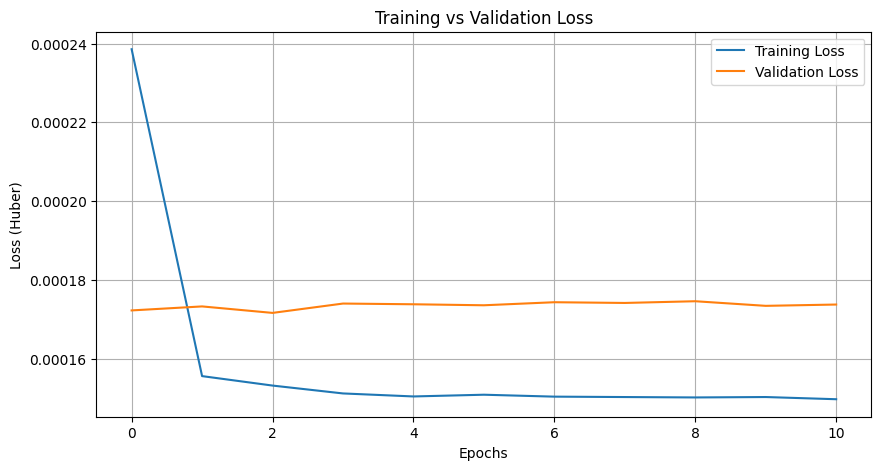

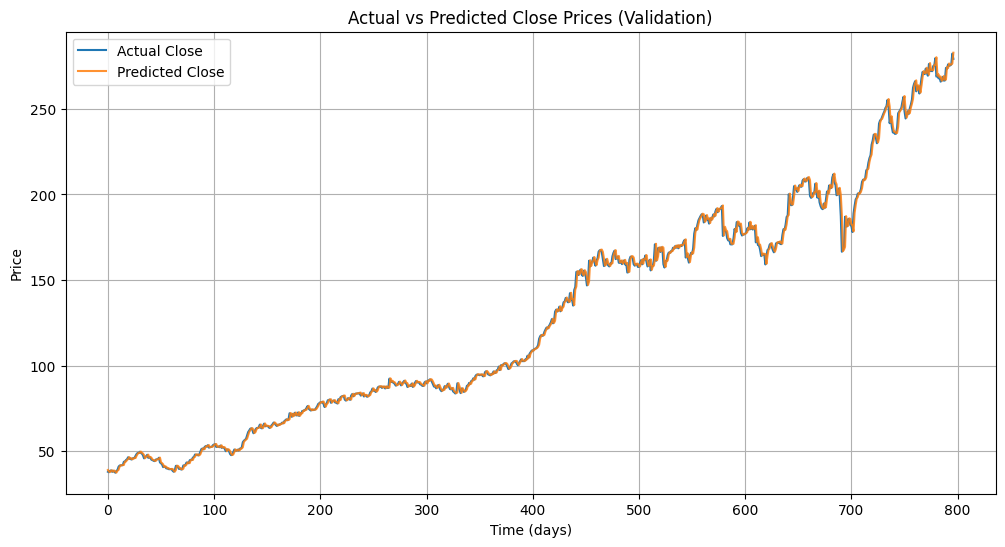


📊 Model Evaluation Metrics:
 MSE                 : 7.472864
 RMSE                : 2.733654
 MAE                 : 1.698012
 MAPE                : 1.32%
 R²                  : 0.998307
 Directional Accuracy: 57.72%
 Theil’s U1          : 0.009384

🔮 10-Day Forecasted Close Prices:
[279.7563  280.27264 280.8002  281.32712 281.84573 282.38284 282.9156
 283.44266 283.96707 284.47668]


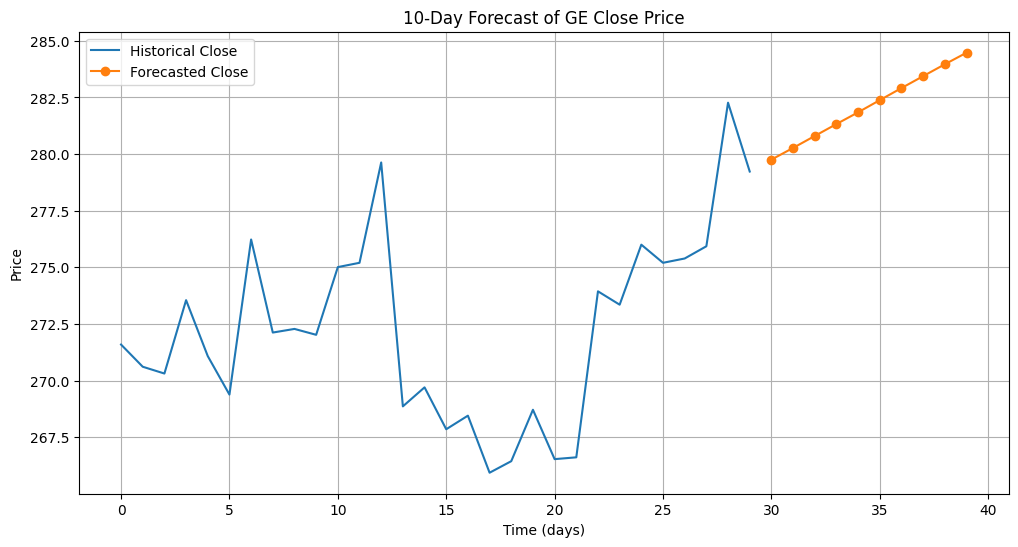

In [4]:
# ================================
# Hybrid ConvLSTM + Temporal Attention + TES feature
# with Bayesian Optimization (KerasTuner) — FAST mode (AMP + XLA + tf.data)
# ================================
import os, sys, subprocess, random, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- Colab: ensure GPU runtime is enabled (Runtime > Change runtime type > GPU) ----

# ============ SPEED SWITCH ============
FAST = True           # <— flip to False for thorough search
TRIALS = 6 if FAST else 15
SEARCH_EPOCHS = 8 if FAST else 15
FINAL_EPOCHS = 40 if FAST else 100
# =====================================

# Silence TF warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
if FAST:
    # Deterministic ops can slow down on GPU. Turn it off for speed.
    os.environ.pop("TF_DETERMINISTIC_OPS", None)

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Ensure keras-tuner is available ---
try:
    import keras_tuner as kt
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "keras-tuner"])
    import keras_tuner as kt

# ============ Global perf boosters ============
# Mixed precision (AMP)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
# XLA JIT
tf.config.optimizer.set_jit(True)
# =============================================

# ================================
# 0) Reproducibility (light)
# ================================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

# ================================
# 1) Load & clean data
# ================================
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"   # change if needed
data_org = pd.read_excel(EXCEL_PATH)

cols_to_drop = [
    'Adj Close_(GE)', 'Adj Close_AEROSPACE', 'Close_(GE)', 'Close_AEROSPACE',
    'High_(GE)', 'High_AEROSPACE', 'Low_(GE)', 'Low_AEROSPACE',
    'Open_(GE)', 'Open_AEROSPACE', 'Volume_(GE)', 'Volume_AEROSPACE'
]
data_org = data_org.drop(columns=[c for c in cols_to_drop if c in data_org.columns], errors="ignore")

data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE': 'High',
    'Low_GE': 'Low',
    'Open_GE': 'Open',
    'Volume_GE': 'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ================================
# 2) TES (Triple Exponential Smoothing)
# ================================
def holt_winters_additive(y, season_length=12, alpha=0.5, beta=0.3, gamma=0.1):
    y = np.asarray(y, dtype=np.float32)
    n = len(y)
    L = np.zeros(n, dtype=np.float32); B = np.zeros(n, dtype=np.float32)
    S = np.zeros(n + season_length, dtype=np.float32)
    L[0] = y[0]
    B[0] = (y[1]-y[0]) if n > 1 else 0.0
    # S initialized to 0 for first season
    for t in range(1, n):
        lt = alpha*(y[t] - S[t]) + (1-alpha)*(L[t-1] + B[t-1])
        bt = beta*(lt - L[t-1]) + (1-beta)*B[t-1]
        st = gamma*(y[t] - lt) + (1-gamma)*S[t - season_length]
        L[t], B[t], S[t] = lt, bt, st
    return L + B + S[:n]

data_org["TES_Close"] = holt_winters_additive(
    data_org["Close"].values, season_length=12, alpha=0.5, beta=0.3, gamma=0.1
).astype(np.float32)

# ================================
# 3) Build sequences (return target)
# ================================
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
raw_values = data_org[num_cols].astype(np.float32).values
CLOSE_IDX = num_cols.index("Close")

def create_sequences_for_return(data, seq_len=90):
    X, y_ret, last_close = [], [], []
    for i in range(len(data) - seq_len):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

SEQ_LEN = 90
X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN)

split = int(0.95 * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ================================
# 4) Scaling
# ================================
robust_scaler_X = RobustScaler()
minmax_scaler_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_scaler_X.fit(flat_train)
train_robust = robust_scaler_X.transform(flat_train)
minmax_scaler_X.fit(train_robust)
train_scaled = minmax_scaler_X.transform(train_robust)
X_train = train_scaled.reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_scaler_X.transform(
            robust_scaler_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

# ConvLSTM expects (B,T,R,F,C)
n_features = X_train.shape[-1]
X_train = X_train.reshape((-1, SEQ_LEN, 1, n_features, 1)).astype(np.float16)  # AMP
X_val   = X_val.reshape((-1, SEQ_LEN, 1, n_features, 1)).astype(np.float16)
y_train = y_ret_train.reshape(-1, 1).astype(np.float32)  # targets stay float32
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ================================
# 4.5) tf.data pipeline (cache + prefetch)
# ================================
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(8192, seed=SEED)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache()

# Optional quick preview (not used later)
_ = train_ds.batch(64).prefetch(AUTOTUNE)
_ = val_ds.batch(64).prefetch(AUTOTUNE)

# ================================
# 5) Temporal Self-Attention
# ================================
class TemporalSelfAttention(layers.Layer):
    def build(self, input_shape):
        self.T = int(input_shape[1]); self.R = int(input_shape[2])
        self.F = int(input_shape[3]); self.C = int(input_shape[4])
        D = self.R * self.F * self.C
        self.Wt = self.add_weight(shape=(D,1), initializer="glorot_uniform", name="Wt")
        self.Wq = self.add_weight(shape=(D,D), initializer="glorot_uniform", name="Wq")
        self.Wk = self.add_weight(shape=(D,D), initializer="glorot_uniform", name="Wk")
        self.Wv = self.add_weight(shape=(D,D), initializer="glorot_uniform", name="Wv")
        super().build(input_shape)

    @tf.function  # compile for speed
    def call(self, x):
        B = tf.shape(x)[0]; T,R,F,C = self.T, self.R, self.F, self.C
        xf = tf.reshape(x, (B, T, R*F*C))         # (B,T,D)
        et = tf.matmul(xf, self.Wt)               # (B,T,1)
        alpha = tf.nn.softmax(tf.squeeze(et, -1), axis=1)
        x_temp = xf * tf.expand_dims(alpha, -1)
        Q = tf.matmul(xf, self.Wq); K = tf.matmul(xf, self.Wk); V = tf.matmul(xf, self.Wv)
        scale = tf.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn = tf.matmul(Q, K, transpose_b=True) / scale
        attn = tf.nn.softmax(attn, axis=-1)
        x_self = tf.matmul(attn, V)
        out = x_temp + x_self
        return tf.reshape(out, (B, T, R, F, C))

# ================================
# 6) Model builder (tuner)
# ================================
def build_model(hp: 'kt.HyperParameters'):
    tf.keras.backend.clear_session()

    # Search space (trimmed in FAST)
    filt1 = hp.Int("filt1", 16, 48 if FAST else 64, step=16)
    filt2 = hp.Int("filt2", 32, 96 if FAST else 128, step=32)
    kf    = hp.Choice("k_feat", values=[3,5])
    drop  = hp.Choice("dropout", values=[0.0, 0.1, 0.2, 0.3] if FAST else [0.0,0.1,0.2,0.3,0.4])
    # recurrent_dropout disables fast cuDNN path; avoid in FAST
    rdrop = hp.Choice("recurrent_dropout", values=[0.0] if FAST else [0.0, 0.2, 0.3, 0.4])
    dense = hp.Int("dense_units", 128, 384 if FAST else 512, step=128)
    lr    = hp.Choice("lr", values=[1e-3, 3e-4] if FAST else [1e-4, 3e-4, 1e-3])
    huber_delta = hp.Choice("huber_delta", values=[1.0] if FAST else [0.5, 1.0, 1.5])
    batch_size = hp.Choice("batch_size", values=[64, 96, 128] if FAST else [32, 64, 96, 128])

    inp = layers.Input(shape=(SEQ_LEN, 1, n_features, 1))

    x = layers.ConvLSTM2D(
        filters=filt1, kernel_size=(1,kf), padding="same", return_sequences=True,
        activation="relu", dropout=drop, recurrent_dropout=rdrop
    )(inp)
    x = layers.LayerNormalization(dtype="float32")(x)  # keep norms in fp32 for stability

    x = TemporalSelfAttention()(x)

    x = layers.ConvLSTM2D(
        filters=filt2, kernel_size=(1,kf), padding="same", return_sequences=True,
        activation="relu", dropout=drop, recurrent_dropout=rdrop
    )(x)
    x = layers.LayerNormalization(dtype="float32")(x)

    x_last = layers.Lambda(lambda z: z[:, -1])(x)
    x_last = layers.SpatialDropout2D(0.1)(x_last)
    x_last = layers.Flatten()(x_last)
    x_last = layers.Dense(dense, activation="relu")(x_last)
    x_last = layers.Dropout(0.5)(x_last)
    out = layers.Dense(1, activation="linear", dtype="float32")(x_last)  # force fp32 output

    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    # stash batch_size for readability (not strictly required)
    model._tuner_bs = batch_size
    return model

# ================================
# 7) Tuner (BayesianOptimization) — fixed subclass
# ================================
early = callbacks.EarlyStopping(monitor="val_loss", patience=6 if FAST else 10,
                                restore_best_weights=True, verbose=0)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                     patience=3 if FAST else 5, min_lr=1e-6, verbose=0)

# KerasTuner can expose BO in two places depending on version
try:
    BO = kt.BayesianOptimization
except AttributeError:
    BO = kt.tuners.BayesianOptimization

class MyTuner(BO):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        bs = hp.get("batch_size")
        kwargs["callbacks"] = [early, reduce]
        kwargs["epochs"] = SEARCH_EPOCHS
        kwargs["verbose"] = 1
        kwargs["validation_data"] = val_ds.batch(bs).prefetch(tf.data.AUTOTUNE)
        return super().run_trial(
            trial,
            train_ds.batch(bs).prefetch(tf.data.AUTOTUNE),
            *args, **kwargs
        )

tuner = MyTuner(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=TRIALS,
    num_initial_points=3 if FAST else 5,
    directory="/content/tuner_logs",
    project_name="convLSTM_temporal_attention_BO_amp_xla",
    overwrite=True
)

tuner.search()

best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
best_bs = best_hp.get("batch_size")
print("Best HP:", best_hp.values)
print(f"Using batch_size={best_bs}")

# ================================
# 8) Final training (short finetune)
# ================================
final_callbacks = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3 if FAST else 5, min_lr=1e-6, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=8 if FAST else 12, restore_best_weights=True, verbose=1),
]
history = best_model.fit(
    train_ds.batch(best_bs).prefetch(AUTOTUNE),
    validation_data=val_ds.batch(best_bs).prefetch(AUTOTUNE),
    epochs=FINAL_EPOCHS,
    verbose=1,
    callbacks=final_callbacks
)

# ================================
# 9) Plots & Evaluation
# ================================
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss (Huber)"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.show()

y_val_pred_ret = best_model.predict(val_ds.batch(best_bs).prefetch(AUTOTUNE), verbose=0).flatten()
y_val_true_ret = y_val.flatten()

y_val_pred_close = last_close_val * (1 + y_val_pred_ret)
y_val_true_close = last_close_val * (1 + y_val_true_ret)

plt.figure(figsize=(12,6))
plt.plot(y_val_true_close, label="Actual Close")
plt.plot(y_val_pred_close, label="Predicted Close", alpha=0.85)
plt.title("Actual vs Predicted Close Prices (Validation)")
plt.xlabel("Time (days)"); plt.ylabel("Price"); plt.legend(); plt.grid(True); plt.show()

mse = mean_squared_error(y_val_true_close, y_val_pred_close)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_true_close, y_val_pred_close)
mape = np.mean(np.abs((y_val_true_close - y_val_pred_close) / (y_val_true_close + 1e-8))) * 100
r2  = r2_score(y_val_true_close, y_val_pred_close)
directional_accuracy = np.mean(np.sign(y_val_true_ret) == np.sign(y_val_pred_ret)) * 100

def theils_u1(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mse_ = np.mean((y_true - y_pred)**2)
    denom = np.sqrt(np.mean(y_true**2)) + np.sqrt(np.mean(y_pred**2))
    return np.sqrt(mse_) / denom

u1 = theils_u1(y_val_true_close, y_val_pred_close)

print("\n📊 Model Evaluation Metrics:")
print(f" MSE                 : {mse:.6f}")
print(f" RMSE                : {rmse:.6f}")
print(f" MAE                 : {mae:.6f}")
print(f" MAPE                : {mape:.2f}%")
print(f" R²                  : {r2:.6f}")
print(f" Directional Accuracy: {directional_accuracy:.2f}%")
print(f" Theil’s U1          : {u1:.6f}")

# ================================
# 10) 10-step forward forecast
# ================================
def prepare_input_window(window, robust_scaler, minmax_scaler):
    win_scaled = minmax_scaler.transform(robust_scaler.transform(window))
    win_scaled = win_scaled.reshape(1, window.shape[0], 1, window.shape[1], 1).astype(np.float16)
    return win_scaled

n_forecast = 10
forecasted_returns, forecasted_close = [], []
last_window = raw_values[-SEQ_LEN:].copy()
last_close  = raw_values[-1, CLOSE_IDX]

for step in range(n_forecast):
    X_input = prepare_input_window(last_window, robust_scaler_X, minmax_scaler_X)
    pred_ret = best_model.predict(X_input, verbose=0).flatten()[0]
    forecasted_returns.append(pred_ret)
    next_close = last_close * (1 + float(pred_ret))
    forecasted_close.append(next_close)
    new_row = last_window[-1].copy()
    new_row[CLOSE_IDX] = next_close
    tes_idx = num_cols.index("TES_Close")
    new_row[tes_idx] = next_close  # fast update; recompute TES for rigor if needed
    last_window = np.vstack([last_window[1:], new_row])
    last_close = next_close

print("\n🔮 10-Day Forecasted Close Prices:")
print(np.array(forecasted_close))

plt.figure(figsize=(12,6))
hist = data_org["Close"].values
tail = hist[-30:] if len(hist) >= 30 else hist
plt.plot(tail, label="Historical Close")
plt.plot(range(len(tail), len(tail)+n_forecast), forecasted_close, marker="o", label="Forecasted Close")
plt.title("10-Day Forecast of GE Close Price")
plt.xlabel("Time (days)"); plt.ylabel("Price"); plt.legend(); plt.grid(True); plt.show()


#TES_DA_CONVLSTM_BO

*   List item

*   List item
*   List item


*   List item



In [3]:
# ============================================================
# Returns-Target Pipeline + TES/DES features + ConvLSTM Enc-Dec
# AMP + XLA + tf.data + Bayesian Optimization (KerasTuner)
# Train/Val evaluations: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, subprocess, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Ensure keras-tuner ----------
try:
    import keras_tuner as kt
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "keras-tuner"])
    import keras_tuner as kt

# ---- Optional: DES via statsmodels (engineered feature) ----
try:
    from statsmodels.tsa.holtwinters import Holt
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "statsmodels"])
    from statsmodels.tsa.holtwinters import Holt

# ============ SPEED / STABILITY ============
FAST = True
SEARCH_TRIALS   = 8 if FAST else 20
SEARCH_EPOCHS   = 8 if FAST else 15
FINAL_EPOCHS    = 40 if FAST else 100

# AMP + XLA
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

cols_to_drop = [
    'Adj Close_(GE)', 'Adj Close_AEROSPACE', 'Close_(GE)', 'Close_AEROSPACE',
    'High_(GE)', 'High_AEROSPACE', 'Low_(GE)', 'Low_AEROSPACE',
    'Open_(GE)', 'Open_AEROSPACE', 'Volume_(GE)', 'Volume_AEROSPACE'
]
data_org = data_org.drop(columns=[c for c in cols_to_drop if c in data_org.columns], errors="ignore")

data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) TES (Triple Exponential Smoothing) + DES ============
def holt_winters_additive(y, season_length=12, alpha=0.5, beta=0.3, gamma=0.1):
    y = np.asarray(y, dtype=np.float32)
    n = len(y)
    L = np.zeros(n, dtype=np.float32)
    B = np.zeros(n, dtype=np.float32)
    S = np.zeros(n + season_length, dtype=np.float32)
    L[0] = y[0]
    B[0] = (y[1]-y[0]) if n > 1 else 0.0
    for t in range(1, n):
        lt = alpha*(y[t] - S[t]) + (1-alpha)*(L[t-1] + B[t-1])
        bt = beta*(lt - L[t-1]) + (1-beta)*B[t-1]
        st = gamma*(y[t] - lt) + (1-gamma)*S[t - season_length]
        L[t], B[t], S[t] = lt, bt, st
    return L + B + S[:n]

data_org["TES_Close"] = holt_winters_additive(
    data_org["Close"].values, season_length=12, alpha=0.5, beta=0.3, gamma=0.1
).astype(np.float32)

try:
    des_fit = Holt(data_org["Close"].values.astype(float), initialization_method='estimated').fit(optimized=True)
    data_org["DES_Close"] = des_fit.fittedvalues.astype(np.float32)
except Exception:
    data_org["DES_Close"] = data_org["TES_Close"].astype(np.float32)

# ============ 3) Sequences (returns target) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values

def create_sequences_for_return(data, seq_len=90):
    X, y_ret, last_close = [], [], []
    for i in range(len(data) - seq_len):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN)

split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 4) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]
X_train = X_train.reshape((-1, SEQ_LEN, 1, n_features, 1)).astype(np.float16)  # AMP
X_val   = X_val.reshape((-1, SEQ_LEN, 1, n_features, 1)).astype(np.float16)

y_train = y_ret_train.reshape(-1, 1).astype(np.float32)
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ============ 4.5) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
# batch size will be hyperparameter; we'll batch inside tuner
base_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(8192, seed=SEED)
base_val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache()

# ============ 5) Model builder (Bayesian Optimization) ============
def build_model(hp: 'kt.HyperParameters'):
    tf.keras.backend.clear_session()

    # Hyperparameters
    enc_filters = hp.Choice("enc_filters", values=[16, 32, 48, 64])
    # Must match for decoder (state-depth constraint)
    dec_filters = enc_filters
    kernel_w    = hp.Choice("kernel_w", values=[1, 3, 5])
    dropout     = hp.Choice("dropout", values=[0.0, 0.1, 0.2, 0.3])
    lr          = hp.Choice("lr", values=[1e-3, 5e-4, 3e-4])
    huber_delta = hp.Choice("huber_delta", values=[0.5, 1.0, 1.5])
    # Batch size chosen here; used in tuner run_trial
    batch_size  = hp.Choice("batch_size", values=[64, 96, 128] if FAST else [32, 48, 64, 96, 128])

    inp = layers.Input(shape=(SEQ_LEN, 1, n_features, 1))

    # Encoder
    enc_out, enc_h, enc_c = layers.ConvLSTM2D(
        filters=enc_filters, kernel_size=(1, kernel_w), padding="same",
        activation="relu", return_sequences=False, return_state=True,
        dropout=dropout
    )(inp)  # (1, n_features, enc_filters)

    # Repeat for decoder step, restore spatial map (H=1, W=n_features, C=enc_filters)
    x = layers.Flatten()(enc_out)
    x = layers.RepeatVector(1)(x)
    x = layers.Reshape((1, 1, n_features, enc_filters))(x)

    # Decoder (filters == enc_filters)
    dec_seq = layers.ConvLSTM2D(
        filters=dec_filters, kernel_size=(1, 1), padding="same",
        activation="relu", return_sequences=True, dropout=dropout
    )(x, initial_state=[enc_h, enc_c])

    # Head
    dec_maps   = layers.TimeDistributed(layers.Conv2D(1, (1,1), padding="same"))(dec_seq)
    dec_pooled = layers.TimeDistributed(layers.GlobalAveragePooling2D())(dec_maps)
    out = layers.TimeDistributed(layers.Dense(1, activation="linear", dtype="float32"))(dec_pooled)
    out = layers.Reshape((1,))(out)

    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    # stash batch size for tuner
    model._tuner_bs = batch_size
    return model

# Early stopping / LR scheduler during search
early = callbacks.EarlyStopping(monitor="val_loss", patience=6 if FAST else 10, restore_best_weights=True, verbose=0)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3 if FAST else 5, min_lr=1e-6, verbose=0)

# Some versions expose BO differently
try:
    BO = kt.BayesianOptimization
except AttributeError:
    BO = kt.tuners.BayesianOptimization

class MyTuner(BO):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        hp = trial.hyperparameters
        bs = hp.get("batch_size")
        train_ds = base_train_ds.batch(bs).prefetch(AUTOTUNE)
        val_ds   = base_val_ds.batch(bs).prefetch(AUTOTUNE)
        fit_kwargs.update({
            "epochs": SEARCH_EPOCHS,
            "callbacks": [early, reduce],
            "validation_data": val_ds,
            "verbose": 1
        })
        return super().run_trial(trial, train_ds, *fit_args, **fit_kwargs)

tuner = MyTuner(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=SEARCH_TRIALS,
    num_initial_points=3 if FAST else 5,
    directory="/content/tuner_logs",
    project_name="convLSTM_returns_BO",
    overwrite=True
)

print(">>> Starting Bayesian Optimization...")
tuner.search()
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:")
print(best_hp.values)

best_model = tuner.get_best_models(1)[0]
best_bs = best_hp.get("batch_size")

# ============ 6) Final training (fine-tune best) ============
final_es  = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
final_rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

train_ds = base_train_ds.batch(best_bs).prefetch(AUTOTUNE)
val_ds   = base_val_ds.batch(best_bs).prefetch(AUTOTUNE)

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINAL_EPOCHS,
    verbose=1,
    callbacks=[final_es, final_rlr]
)

# ============ 7) Predict ============
y_pred_train_ret = best_model.predict(train_ds, verbose=0).reshape(-1)
y_pred_val_ret   = best_model.predict(val_ds,   verbose=0).reshape(-1)

y_true_train_ret = y_train.reshape(-1)
y_true_val_ret   = y_val.reshape(-1)

# Reconstruct close from returns base
y_pred_train_close = last_close_train * (1.0 + y_pred_train_ret)
y_true_train_close = last_close_train * (1.0 + y_true_train_ret)
y_pred_val_close   = last_close_val   * (1.0 + y_pred_val_ret)
y_true_val_close   = last_close_val   * (1.0 + y_true_val_ret)

# ============ 8) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

# non-target features count (Open/High/Low/Vol/TES/DES/...)
p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close, y_pred_val_close,
                             y_true_val_ret,   y_pred_val_ret)

# ============ 9) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (Best Model)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (Best Model)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (Best Model)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


AssertionError: File not found: /content/GE1.xlsx

#TES_DA_ED_CONVLSTM_BO

Trial 8 Complete [00h 01m 59s]
val_loss: 0.0002114060043822974

Best val_loss So Far: 0.0002114060043822974
Total elapsed time: 00h 15m 57s

Best Hyperparameters:
{'enc_filters': 64, 'kernel_w': 3, 'dropout': 0.3, 'lr': 0.001, 'huber_delta': 1.0, 'batch_size': 64, 'num_heads': 4, 'key_dim': 8, 'attn_dropout': 0.0, 'se_reduction': 16}
Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - loss: 1.2489e-04 - mse: 2.4978e-04 - val_loss: 2.1166e-04 - val_mse: 4.2333e-04 - learning_rate: 0.0010
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 1.2055e-04 - mse: 2.4110e-04 - val_loss: 2.1211e-04 - val_mse: 4.2422e-04 - learning_rate: 0.0010
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 1.2177e-04 - mse: 2.4353e-04 - val_loss: 2.1184e-04 - val_mse: 4.2367e-04 - learning_rate: 0.0010
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 1.2217e-04 - mse: 2.4434e-04 - val_loss: 2.1140e-04 - val_mse: 4.2279e-04 - learning_rate: 0.0010
Epoch 5/40
199/200 ━━━━

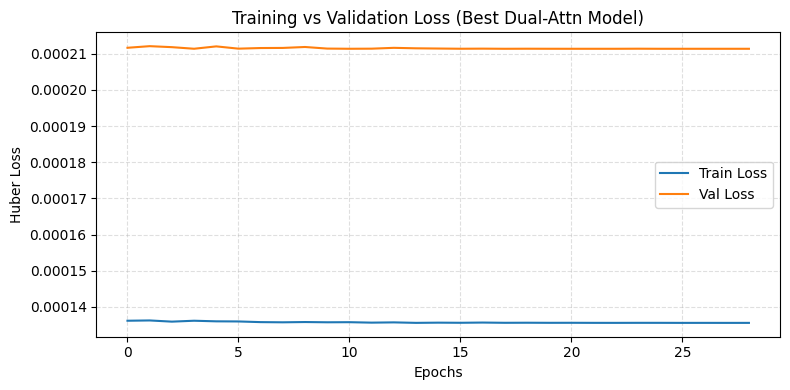

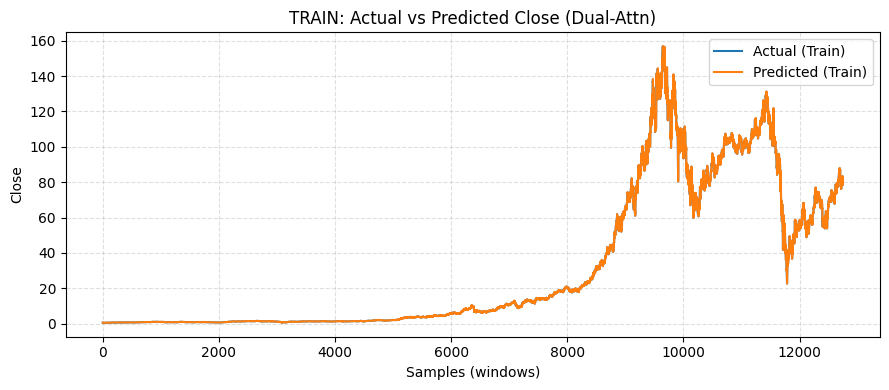

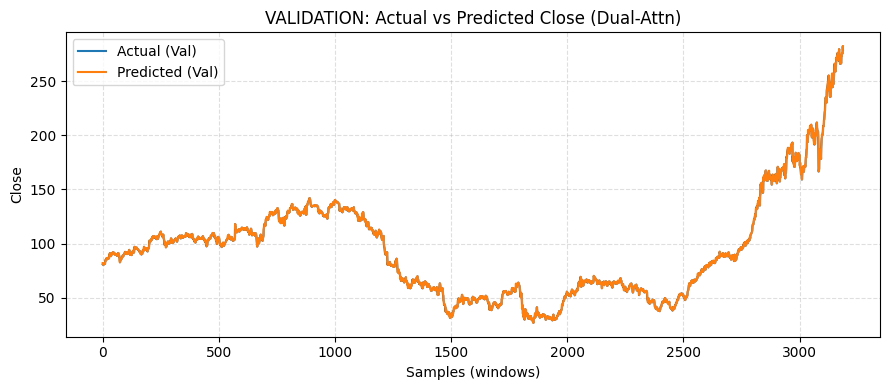


Summary:
                  MSE       MAE      RMSE        R2     AdjR2         DA  \
Train       0.923268  0.407126  0.960868  0.999445  0.999445  48.074359   
Validation  3.150244  1.129312  1.774893  0.998631  0.998628  50.595985   

                  U1  
Train       0.009342  
Validation  0.008350  


In [2]:
# ============================================================
# Returns-Target + TES/DES + Dual Attention (Temporal MHA + SE)
# ConvLSTM Enc-Dec + AMP + XLA + tf.data + Bayesian Optimization
# Evaluations: MSE, MAE, RMSE, R², Adj R², Directional Acc., Theil's U1
# ============================================================
import os, sys, math, warnings, subprocess, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Ensure keras-tuner ----------
try:
    import keras_tuner as kt
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "keras-tuner"])
    import keras_tuner as kt

# ---- Optional: DES via statsmodels (engineered feature) ----
try:
    from statsmodels.tsa.holtwinters import Holt
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "statsmodels"])
    from statsmodels.tsa.holtwinters import Holt

# ============ SPEED / STABILITY ============
FAST = True
SEARCH_TRIALS   = 8 if FAST else 20
SEARCH_EPOCHS   = 8 if FAST else 15
FINAL_EPOCHS    = 40 if FAST else 100

# AMP + XLA
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"   # change if needed
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

cols_to_drop = [
    'Adj Close_(GE)', 'Adj Close_AEROSPACE', 'Close_(GE)', 'Close_AEROSPACE',
    'High_(GE)', 'High_AEROSPACE', 'Low_(GE)', 'Low_AEROSPACE',
    'Open_(GE)', 'Open_AEROSPACE', 'Volume_(GE)', 'Volume_AEROSPACE'
]
data_org = data_org.drop(columns=[c for c in cols_to_drop if c in data_org.columns], errors="ignore")

data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) TES (Triple Exponential Smoothing) + DES ============
def holt_winters_additive(y, season_length=12, alpha=0.5, beta=0.3, gamma=0.1):
    y = np.asarray(y, dtype=np.float32)
    n = len(y)
    L = np.zeros(n, dtype=np.float32); B = np.zeros(n, dtype=np.float32)
    S = np.zeros(n + season_length, dtype=np.float32)
    L[0] = y[0]; B[0] = (y[1]-y[0]) if n > 1 else 0.0
    for t in range(1, n):
        lt = alpha*(y[t] - S[t]) + (1-alpha)*(L[t-1] + B[t-1])
        bt = beta*(lt - L[t-1]) + (1-beta)*B[t-1]
        st = gamma*(y[t] - lt) + (1-gamma)*S[t - season_length]
        L[t], B[t], S[t] = lt, bt, st
    return L + B + S[:n]

data_org["TES_Close"] = holt_winters_additive(
    data_org["Close"].values, season_length=12, alpha=0.5, beta=0.3, gamma=0.1
).astype(np.float32)

try:
    des_fit = Holt(data_org["Close"].values.astype(float), initialization_method='estimated').fit(optimized=True)
    data_org["DES_Close"] = des_fit.fittedvalues.astype(np.float32)
except Exception:
    data_org["DES_Close"] = data_org["TES_Close"].astype(np.float32)

# ============ 3) Sequences (returns target) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values

def create_sequences_for_return(data, seq_len=90):
    X, y_ret, last_close = [], [], []
    for i in range(len(data) - seq_len):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN)

split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 4) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]
X_train = X_train.reshape((-1, SEQ_LEN, 1, n_features, 1)).astype(np.float16)  # AMP
X_val   = X_val.reshape((-1, SEQ_LEN, 1, n_features, 1)).astype(np.float16)

y_train = y_ret_train.reshape(-1, 1).astype(np.float32)
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ============ 4.5) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
base_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(8192, seed=SEED)
base_val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache()

# ============ 5) Dual Attention Blocks ============
def squeeze_HC_to_TF(x5d):
    # (B,T,1,F,1) -> (B,T,F)
    return tf.squeeze(x5d, axis=[2,4])

def expand_TF_to_5D(x3d):
    # (B,T,F) -> (B,T,1,F,1)
    x3d = tf.expand_dims(x3d, axis=2)  # H=1
    x3d = tf.expand_dims(x3d, axis=4)  # C=1
    return x3d

def channel_se_block(x_TF, reduction=8):
    # x_TF: (B,T,F)
    gap = layers.GlobalAveragePooling1D(keepdims=True)(x_TF)  # (B,1,F)
    f = int(x_TF.shape[-1])
    hidden = max(1, f // reduction)
    s = layers.Dense(hidden, activation="relu")(gap)
    s = layers.Dense(f, activation="sigmoid")(s)
    return layers.Multiply()([x_TF, s])  # broadcast over T

# ============ 6) Model builder (Bayesian Optimization with Dual Attention) ============
def build_model(hp: 'kt.HyperParameters'):
    tf.keras.backend.clear_session()

    # Hyperparameters
    enc_filters = hp.Choice("enc_filters", values=[16, 32, 48, 64])
    dec_filters = enc_filters  # must match state depth
    kernel_w    = hp.Choice("kernel_w", values=[1, 3, 5])
    dropout     = hp.Choice("dropout", values=[0.0, 0.1, 0.2, 0.3])
    lr          = hp.Choice("lr", values=[1e-3, 5e-4, 3e-4])
    huber_delta = hp.Choice("huber_delta", values=[0.5, 1.0, 1.5])
    batch_size  = hp.Choice("batch_size", values=[64, 96, 128] if FAST else [32, 48, 64, 96, 128])

    # Dual attention params
    num_heads   = hp.Choice("num_heads", values=[1, 2, 4])
    key_dim     = hp.Choice("key_dim",   values=[8, 16, 32])
    attn_drop   = hp.Choice("attn_dropout", values=[0.0, 0.1, 0.2])
    se_reduce   = hp.Choice("se_reduction", values=[4, 8, 16])

    inp = layers.Input(shape=(SEQ_LEN, 1, n_features, 1))

    # ---- (A) Temporal Self-Attention on (B,T,F) ----
    x_TF = layers.Lambda(squeeze_HC_to_TF, name="squeeze_to_TF")(inp)     # (B,T,F)
    # Project (optional) before MHA
    x_proj = layers.Dense(n_features, activation="linear")(x_TF)
    # Keras MHA handles projection internally; use causal mask for forecasting
    mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim,
                                    dropout=attn_drop)(x_proj, x_proj, use_causal_mask=True)
    x_ta = layers.Add()([x_proj, mha])
    x_ta = layers.LayerNormalization(dtype="float32")(x_ta)

    # ---- (B) Channel/Feature Attention (SE) ----
    x_ca = channel_se_block(x_ta, reduction=se_reduce)
    x_ca = layers.LayerNormalization(dtype="float32")(x_ca)

    # Residual merge with original inputs
    x_fused = layers.Add()([x_TF, x_ca])      # (B,T,F)

    # Back to 5D for ConvLSTM
    x5 = layers.Lambda(expand_TF_to_5D, name="expand_to_5D")(x_fused)     # (B,T,1,F,1)

    # ---- Encoder ConvLSTM (return state) ----
    enc_out, enc_h, enc_c = layers.ConvLSTM2D(
        filters=enc_filters, kernel_size=(1, kernel_w), padding="same",
        activation="relu", return_sequences=False, return_state=True,
        dropout=dropout
    )(x5)  # (1, F, enc_filters)

    # Prepare 1-step decoder input from encoder context
    d = layers.Flatten()(enc_out)
    d = layers.RepeatVector(1)(d)
    d = layers.Reshape((1, 1, n_features, enc_filters))(d)  # (time=1, H=1, W=F, C=enc_filters)

    # ---- Decoder ConvLSTM ----
    dec_seq = layers.ConvLSTM2D(
        filters=dec_filters, kernel_size=(1, 1), padding="same",
        activation="relu", return_sequences=True, dropout=dropout
    )(d, initial_state=[enc_h, enc_c])

    # Head
    dec_maps   = layers.TimeDistributed(layers.Conv2D(1, (1,1), padding="same"))(dec_seq)
    dec_pooled = layers.TimeDistributed(layers.GlobalAveragePooling2D())(dec_maps)
    out = layers.TimeDistributed(layers.Dense(1, activation="linear", dtype="float32"))(dec_pooled)
    out = layers.Reshape((1,))(out)  # one-step return

    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    model._tuner_bs = batch_size
    return model

# Early stopping / LR scheduler during search
early = callbacks.EarlyStopping(monitor="val_loss", patience=6 if FAST else 10, restore_best_weights=True, verbose=0)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3 if FAST else 5, min_lr=1e-6, verbose=0)

# Tuner class with dataset wiring
try:
    BO = kt.BayesianOptimization
except AttributeError:
    BO = kt.tuners.BayesianOptimization

class MyTuner(BO):
    def run_trial(self, trial, *fit_args, **fit_kwargs):
        hp = trial.hyperparameters
        bs = hp.get("batch_size")
        train_ds = base_train_ds.batch(bs).prefetch(AUTOTUNE)
        val_ds   = base_val_ds.batch(bs).prefetch(AUTOTUNE)
        fit_kwargs.update({
            "epochs": SEARCH_EPOCHS,
            "callbacks": [early, reduce],
            "validation_data": val_ds,
            "verbose": 1
        })
        return super().run_trial(trial, train_ds, *fit_args, **fit_kwargs)

tuner = MyTuner(
    hypermodel=build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=SEARCH_TRIALS,
    num_initial_points=3 if FAST else 5,
    directory="/content/tuner_logs",
    project_name="convLSTM_returns_BO_dual_attn",
    overwrite=True
)

print(">>> Starting Bayesian Optimization with Dual Attention...")
tuner.search()
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:")
print(best_hp.values)

best_model = tuner.get_best_models(1)[0]
best_bs = best_hp.get("batch_size")

# ============ 7) Final training (fine-tune best) ============
final_es  = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1)
final_rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

train_ds = base_train_ds.batch(best_bs).prefetch(AUTOTUNE)
val_ds   = base_val_ds.batch(best_bs).prefetch(AUTOTUNE)

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINAL_EPOCHS,
    verbose=1,
    callbacks=[final_es, final_rlr]
)

# ============ 8) Predict ============
y_pred_train_ret = best_model.predict(train_ds, verbose=0).reshape(-1)
y_pred_val_ret   = best_model.predict(val_ds,   verbose=0).reshape(-1)

y_true_train_ret = y_train.reshape(-1)
y_true_val_ret   = y_val.reshape(-1)

# Reconstruct close from returns base
y_pred_train_close = last_close_train * (1.0 + y_pred_train_ret)
y_true_train_close = last_close_train * (1.0 + y_true_train_ret)
y_pred_val_close   = last_close_val   * (1.0 + y_pred_val_ret)
y_true_val_close   = last_close_val   * (1.0 + y_true_val_ret)

# ============ 9) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close, y_pred_val_close,
                             y_true_val_ret,   y_pred_val_ret)

# ============ 10) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (Best Dual-Attn Model)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (Dual-Attn)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (Dual-Attn)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


::#**BiDirectional LSTM**

In [ ]:
# ============================================================
# Returns-Target + **Bi-Directional LSTM only** — FAST edition (patched)
# AMP + XLA + tf.data | Metrics: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------- SPEED SWITCH ----------------
FAST = True                 # << flip to False for better accuracy
EPOCHS       = 100 if FAST else 60       # <<< increased from 20 to 100
BATCH_SIZE   = 256 if FAST else 128
STRIDE       = 3  if FAST else 1         # subsample windows to reduce dataset size
L1_UNITS     = 64 if FAST else 128
L2_UNITS     = 32 if FAST else 64
HEAD_WIDTH   = 48 if FAST else 96
DROPOUT      = 0.1 if FAST else 0.2
REC_DROPOUT  = 0.0                       # keep 0 to enable cuDNN fast path
# ------------------------------------------------------------

# --- Set threading BEFORE TF runtime is initialized ---
try:
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
except RuntimeError:
    # Runtime already initialized: skip without failing
    pass

# AMP + XLA (these lines can initialize runtime)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"   # change if needed
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

# keep only OHLCV (rename if needed)
data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) Sequences (returns target) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values

def create_sequences_for_return(data, seq_len=90, stride=1):
    X, y_ret, last_close = [], [], []
    for i in range(0, len(data) - seq_len, stride):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN, STRIDE)

split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 3) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]

# Keep 3D tensors for BiLSTM (B, T, F); AMP ok (force final outputs to float32)
X_train = X_train.astype(np.float16)
X_val   = X_val.astype(np.float16)

y_train = y_ret_train.reshape(-1, 1).astype(np.float32)
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ============ 4) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .cache()
            .shuffle(min(4096, len(X_train)), seed=SEED)
            .batch(BATCH_SIZE, drop_remainder=True)     # fast training, fixed batch
            .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
            .cache()
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTOTUNE))

# NEW: non-shuffled, non-dropping datasets for evaluation/prediction (to keep shapes aligned)
train_eval_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE, drop_remainder=False)
val_eval_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(BATCH_SIZE, drop_remainder=False)

# ============ 5) Build BiLSTM-only model (cuDNN fast path) ============
def build_bilstm_model(seq_len, n_features,
                       lstm_units1=L1_UNITS, lstm_units2=L2_UNITS,
                       dropout=DROPOUT, recur_drop=REC_DROPOUT,
                       head_width=HEAD_WIDTH, head_drop=DROPOUT,
                       lr=3e-4, huber_delta=1.0):
    inp = layers.Input(shape=(seq_len, n_features))  # (B,T,F)

    # cuDNN LSTM triggers when recurrent_dropout==0
    x = layers.Bidirectional(
        layers.LSTM(lstm_units1, return_sequences=True,
                    dropout=dropout, recurrent_dropout=recur_drop)
    )(inp)

    x = layers.Bidirectional(
        layers.LSTM(lstm_units2, return_sequences=False,
                    dropout=dropout, recurrent_dropout=recur_drop)
    )(x)

    x = layers.Dense(head_width, activation="relu")(x)
    if head_drop > 0:
        x = layers.Dropout(head_drop)(x)

    out = layers.Dense(1, activation="linear", dtype="float32")(x)  # 1-step return
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    return model

model = build_bilstm_model(SEQ_LEN, n_features)

# ============ 6) Train ============
early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early, reduce]
)

# ============ 7) Predict ============
# Use the non-dropping, non-shuffled datasets to keep lengths aligned with last_close_* vectors
y_pred_train_ret = model.predict(train_eval_ds, verbose=0).reshape(-1)
y_pred_val_ret   = model.predict(val_eval_ds,   verbose=0).reshape(-1)

y_true_train_ret = y_train.reshape(-1)
y_true_val_ret   = y_val.reshape(-1)

# Reconstruct close from returns base
y_pred_train_close = last_close_train * (1.0 + y_pred_train_ret)
y_true_train_close = last_close_train * (1.0 + y_true_train_ret)
y_pred_val_close   = last_close_val   * (1.0 + y_pred_val_ret)
y_true_val_close   = last_close_val   * (1.0 + y_true_val_ret)

# ============ 8) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close, y_pred_val_close,
                             y_true_val_ret,   y_pred_val_ret)

# ============ 9) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []), label="Train Loss")
plt.plot(history.history.get("val_loss", []), label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (BiLSTM FAST)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (BiLSTM FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (BiLSTM)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


#ED_BI **LSTM**

TF: 2.19.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Columns after cleaning: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        Date      Open      High       Low     Close  Volume
0 1962-01-02  0.621680  0.632041  0.615463  0.619607  432682
1 1962-01-03  0.616498  0.616498  0.611317  0.613390  296467
2 1962-01-04  0.613390  0.618571  0.600957  0.606137  368581
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 5.8098e-04 - mse: 0.0012 - val_loss: 6.1190e-04 - val_mse: 0.0012 - learning_rate: 3.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 2.1492e-04 - mse: 4.2985e-04 - val_loss: 2.5302e-04 - val_mse: 5.0606e-04 - learning_rate: 3.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6333e-04 - mse: 3.2666e-04 - val_loss: 2.3058e-04 - val_mse: 4.6116e-04 - learning_rate: 3.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4447e-04 - mse: 2.8894e-04 - val_loss: 2.3303e-04 - va

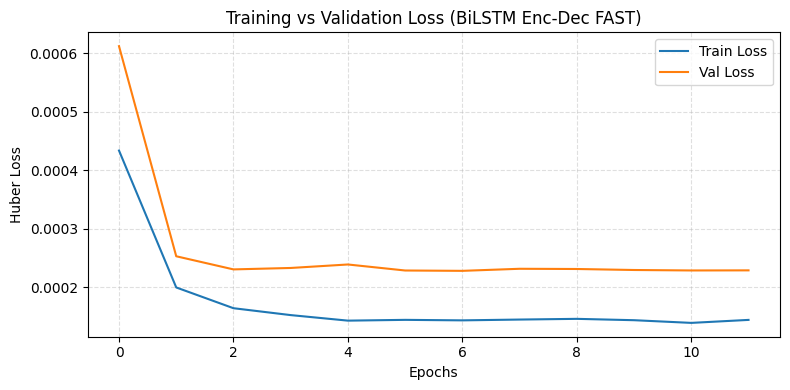

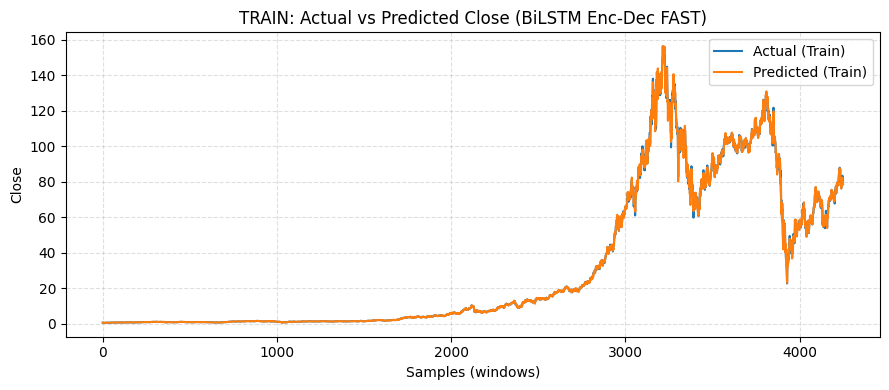

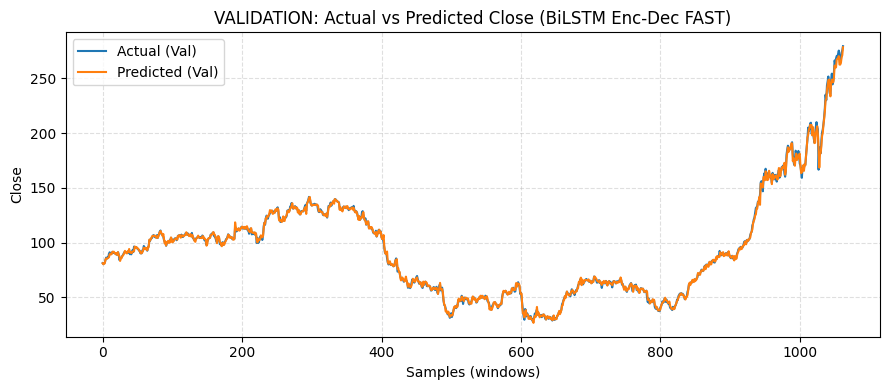


Summary:
                  MSE       MAE      RMSE        R2     AdjR2         DA  \
Train       0.870102  0.396335  0.932793  0.999477  0.999477  48.423529   
Validation  3.814161  1.238168  1.952988  0.998342  0.998336  49.858890   

                  U1  
Train       0.009071  
Validation  0.009200  


In [ ]:
# ============================================================
# Returns-Target + **BiLSTM Encoder–Decoder** — FAST edition (patched, fixed)
# AMP + XLA + tf.data | Metrics: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------- SPEED SWITCH ----------------
FAST = True                     # << flip to False for better accuracy
EPOCHS       = 100 if FAST else 60
BATCH_SIZE   = 256 if FAST else 128
STRIDE       = 3  if FAST else 1      # subsample windows to reduce dataset size
L1_UNITS     = 64 if FAST else 128    # encoder BiLSTM units (per direction)
L2_UNITS     = 32 if FAST else 64     # kept for compatibility; decoder now ties to encoder size
HEAD_WIDTH   = 48 if FAST else 96
DROPOUT      = 0.1 if FAST else 0.2
REC_DROPOUT  = 0.0                    # keep 0 to enable cuDNN fast path
LR           = 3e-4
HUBER_DELTA  = 1.0
# ------------------------------------------------------------

# --- Set threading BEFORE TF runtime is initialized ---
try:
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
except RuntimeError:
    pass

# AMP + XLA
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"   # change if needed
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

# keep only OHLCV (rename if needed)
data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) Sequences (returns target) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values

def create_sequences_for_return(data, seq_len=90, stride=1):
    X, y_ret, last_close = [], [], []
    for i in range(0, len(data) - seq_len, stride):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN, STRIDE)

split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 3) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]

# Keep 3D tensors for BiLSTM (B, T, F); AMP ok (force final outputs to float32)
X_train = X_train.astype(np.float16)
X_val   = X_val.astype(np.float16)

y_train = y_ret_train.reshape(-1, 1).astype(np.float32)
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ============ 4) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .cache()
            .shuffle(min(4096, len(X_train)), seed=SEED)
            .batch(BATCH_SIZE, drop_remainder=True)     # fast training, fixed batch
            .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
            .cache()
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTOTUNE))

# Non-shuffled, non-dropping datasets for evaluation/prediction (keep shapes aligned)
train_eval_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE, drop_remainder=False)
val_eval_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(BATCH_SIZE, drop_remainder=False)

# ============ 5) Build BiLSTM Encoder–Decoder (decoder units match encoder state size) ============
def build_bilstm_encdec(seq_len, n_features,
                        enc_units=L1_UNITS,  # per direction
                        dropout=DROPOUT, recur_drop=REC_DROPOUT,
                        head_width=HEAD_WIDTH, head_drop=DROPOUT,
                        lr=LR, huber_delta=HUBER_DELTA):
    """
    Encoder: Bidirectional LSTM -> concat forward/backward states (h, c) of size 2*enc_units.
    Decoder: Single-step LSTM with units = 2*enc_units, initialized with the encoder states.
    Head:    TimeDistributed Dense -> 1 linear unit predicting next-step return.
    """
    inp = layers.Input(shape=(seq_len, n_features))  # (B,T,F)

    # ----- Encoder (BiLSTM) -----
    enc_out, h_f, c_f, h_b, c_b = layers.Bidirectional(
        layers.LSTM(enc_units, return_sequences=True, return_state=True,
                    dropout=dropout, recurrent_dropout=recur_drop),
        name="encoder_bilstm"
    )(inp)

    # Concatenate forward/backward states
    state_h = layers.Concatenate(name="enc_h_concat")([h_f, h_b])  # (B, 2*enc_units)
    state_c = layers.Concatenate(name="enc_c_concat")([c_f, c_b])  # (B, 2*enc_units)

    # ----- Decoder (1 step) -----
    # Provide a single-timestep zero vector as decoder input (shape: B x 1 x n_features)
    start_token = layers.Lambda(lambda x: tf.zeros((tf.shape(x)[0], 1, n_features), dtype=x.dtype),
                                name="start_token")(inp)

    # IMPORTANT: decoder units must match encoder state size
    dec_lstm_units = 2 * enc_units
    dec_out = layers.LSTM(dec_lstm_units, return_sequences=True,
                          dropout=dropout, recurrent_dropout=recur_drop,
                          name="decoder_lstm")(start_token, initial_state=[state_h, state_c])  # (B,1,2*enc_units)

    # Head on the decoder output
    dec_feat = layers.TimeDistributed(layers.Dense(head_width, activation="relu"),
                                      name="dec_dense")(dec_out)
    if head_drop > 0:
        dec_feat = layers.TimeDistributed(layers.Dropout(head_drop), name="dec_drop")(dec_feat)

    ret_pred = layers.TimeDistributed(
        layers.Dense(1, activation="linear", dtype="float32"), name="return_head"
    )(dec_feat)  # (B,1,1)

    out = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="squeeze_time")(ret_pred)  # (B,)

    model = models.Model(inp, out, name="BiLSTM_EncDec_Returns")
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    return model

model = build_bilstm_encdec(SEQ_LEN, n_features)

# ============ 6) Train ============
early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early, reduce]
)

# ============ 7) Predict ============
y_pred_train_ret = model.predict(train_eval_ds, verbose=0).reshape(-1)
y_pred_val_ret   = model.predict(val_eval_ds,   verbose=0).reshape(-1)

y_true_train_ret = y_train.reshape(-1)
y_true_val_ret   = y_val.reshape(-1)

# Reconstruct close from returns base
y_pred_train_close = last_close_train * (1.0 + y_pred_train_ret)
y_true_train_close = last_close_train * (1.0 + y_true_train_ret)
y_pred_val_close   = last_close_val   * (1.0 + y_pred_val_ret)
y_true_val_close   = last_close_val   * (1.0 + y_true_val_ret)

# ============ 8) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close, y_pred_val_close,
                             y_true_val_ret,   y_pred_val_ret)

# ============ 9) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []), label="Train Loss")
plt.plot(history.history.get("val_loss", []), label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (BiLSTM Enc-Dec FAST)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (BiLSTM Enc-Dec FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (BiLSTM Enc-Dec FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


#BI **GRU**

TF: 2.19.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Columns after cleaning: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        Date      Open      High       Low     Close  Volume
0 1962-01-02  0.621680  0.632041  0.615463  0.619607  432682
1 1962-01-03  0.616498  0.616498  0.611317  0.613390  296467
2 1962-01-04  0.613390  0.618571  0.600957  0.606137  368581
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 4.8392e-04 - val_mse: 9.6785e-04 - learning_rate: 3.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.6156e-04 - mse: 7.2313e-04 - val_loss: 2.9264e-04 - val_mse: 5.8528e-04 - learning_rate: 3.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.2880e-04 - mse: 4.5760e-04 - val_loss: 2.3231e-04 - val_mse: 4.6462e-04 - learning_rate: 3.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8457e-04 - mse: 3.6914e-04 - val_loss: 2.2785e-04 - va

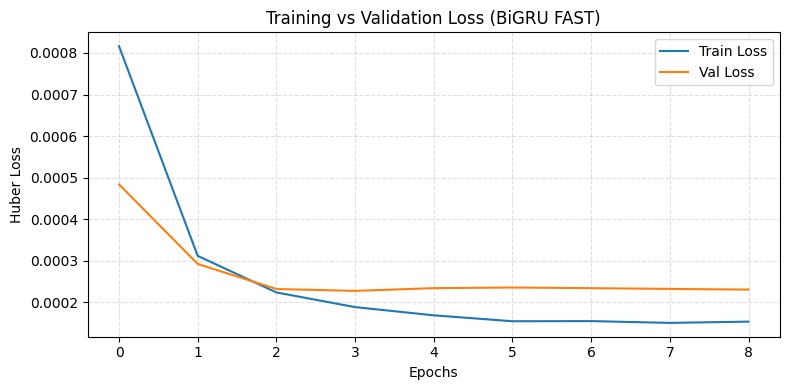

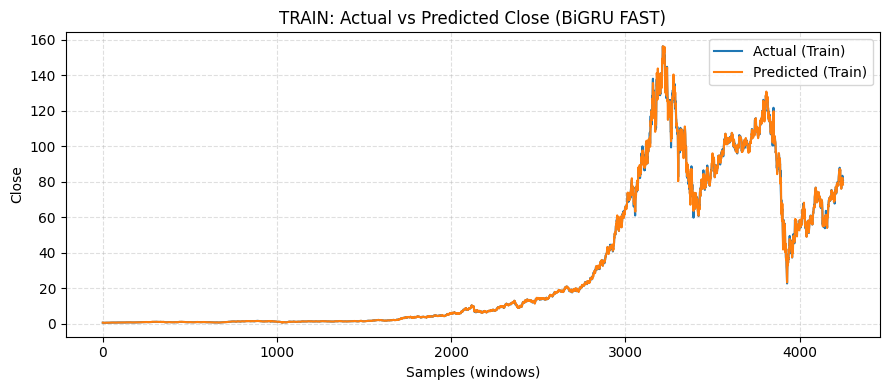

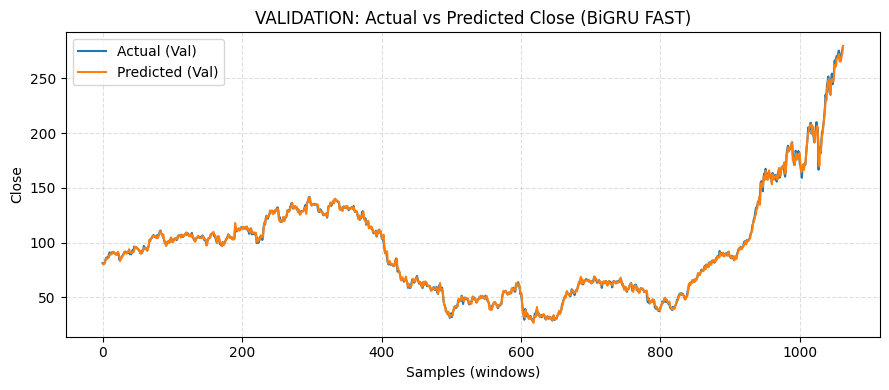


Summary:
                  MSE       MAE      RMSE        R2     AdjR2         DA  \
Train       0.857590  0.392561  0.926062  0.999485  0.999484  48.800000   
Validation  3.660722  1.218110  1.913301  0.998409  0.998403  47.130762   

                  U1  
Train       0.009008  
Validation  0.009007  


In [ ]:
# ============================================================
# Returns-Target + **Bi-Directional GRU only** — FAST edition (patched)
# AMP + XLA + tf.data | Metrics: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------- SPEED SWITCH ----------------
FAST = True                 # << flip to False for better accuracy
EPOCHS       = 100 if FAST else 60
BATCH_SIZE   = 256 if FAST else 128
STRIDE       = 3  if FAST else 1         # subsample windows to reduce dataset size
L1_UNITS     = 64 if FAST else 128
L2_UNITS     = 32 if FAST else 64
HEAD_WIDTH   = 48 if FAST else 96
DROPOUT      = 0.1 if FAST else 0.2
REC_DROPOUT  = 0.0                       # keep 0 to enable cuDNN fast path for GRU
# ------------------------------------------------------------

# --- Set threading BEFORE TF runtime is initialized ---
try:
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
except RuntimeError:
    # Runtime already initialized: skip without failing
    pass

# AMP + XLA (these lines can initialize runtime)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"   # change if needed
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

# keep only OHLCV (rename if needed)
data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) Sequences (returns target) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values

def create_sequences_for_return(data, seq_len=90, stride=1):
    X, y_ret, last_close = [], [], []
    for i in range(0, len(data) - seq_len, stride):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN, STRIDE)

split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 3) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]

# Keep 3D tensors for BiGRU (B, T, F); AMP ok (force final outputs to float32)
X_train = X_train.astype(np.float16)
X_val   = X_val.astype(np.float16)

y_train = y_ret_train.reshape(-1, 1).astype(np.float32)
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ============ 4) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .cache()
            .shuffle(min(4096, len(X_train)), seed=SEED)
            .batch(BATCH_SIZE, drop_remainder=True)     # fast training, fixed batch
            .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
            .cache()
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTOTUNE))

# Non-shuffled, non-dropping datasets for evaluation/prediction (keep shapes aligned)
train_eval_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE, drop_remainder=False)
val_eval_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(BATCH_SIZE, drop_remainder=False)

# ============ 5) Build BiGRU-only model (cuDNN fast path) ============
def build_bigru_model(seq_len, n_features,
                      gru_units1=L1_UNITS, gru_units2=L2_UNITS,
                      dropout=DROPOUT, recur_drop=REC_DROPOUT,
                      head_width=HEAD_WIDTH, head_drop=DROPOUT,
                      lr=3e-4, huber_delta=1.0):
    inp = layers.Input(shape=(seq_len, n_features))  # (B,T,F)

    # cuDNN GRU fast path requires recurrent_dropout==0.0 (we set REC_DROPOUT=0.0 above)
    x = layers.Bidirectional(
        layers.GRU(gru_units1, return_sequences=True,
                   dropout=dropout, recurrent_dropout=recur_drop, reset_after=True)
    )(inp)

    x = layers.Bidirectional(
        layers.GRU(gru_units2, return_sequences=False,
                   dropout=dropout, recurrent_dropout=recur_drop, reset_after=True)
    )(x)

    x = layers.Dense(head_width, activation="relu")(x)
    if head_drop > 0:
        x = layers.Dropout(head_drop)(x)

    out = layers.Dense(1, activation="linear", dtype="float32")(x)  # 1-step return
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    return model

model = build_bigru_model(SEQ_LEN, n_features)

# ============ 6) Train ============
early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early, reduce]
)

# ============ 7) Predict ============
# Use the non-dropping, non-shuffled datasets to keep lengths aligned with last_close_* vectors
y_pred_train_ret = model.predict(train_eval_ds, verbose=0).reshape(-1)
y_pred_val_ret   = model.predict(val_eval_ds,   verbose=0).reshape(-1)

y_true_train_ret = y_train.reshape(-1)
y_true_val_ret   = y_val.reshape(-1)

# Reconstruct close from returns base
y_pred_train_close = last_close_train * (1.0 + y_pred_train_ret)
y_true_train_close = last_close_train * (1.0 + y_true_train_ret)
y_pred_val_close   = last_close_val   * (1.0 + y_pred_val_ret)
y_true_val_close   = last_close_val   * (1.0 + y_true_val_ret)

# ============ 8) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close, y_pred_val_close,
                             y_true_val_ret,   y_pred_val_ret)

# ============ 9) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []), label="Train Loss")
plt.plot(history.history.get("val_loss", []), label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (BiGRU FAST)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (BiGRU FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (BiGRU FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


#ARIMA_BILSTM

TF: 2.19.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Columns after cleaning: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        Date      Open      High       Low     Close  Volume
0 1962-01-02  0.621680  0.632041  0.615463  0.619607  432682
1 1962-01-03  0.616498  0.616498  0.611317  0.613390  296467
2 1962-01-04  0.613390  0.618571  0.600957  0.606137  368581
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - loss: 0.0030 - mse: 0.0061 - val_loss: 37.5585 - val_mse: 2565.8152 - learning_rate: 3.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0033 - mse: 0.0066 - val_loss: 37.5675 - val_mse: 2566.9812 - learning_rate: 3.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - mse: 0.0058 - val_loss: 37.5586 - val_mse: 2565.8298 - learning_rate: 3.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - mse: 0.0069 - val_loss: 37.5639 - val_mse: 2566.7126 - learning_rate: 3.000

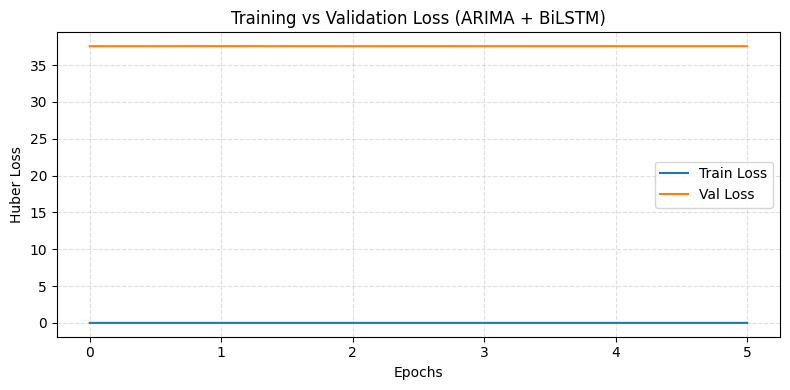

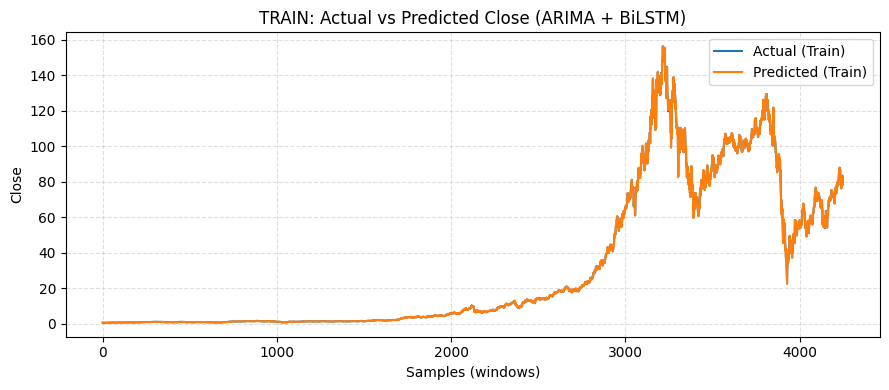

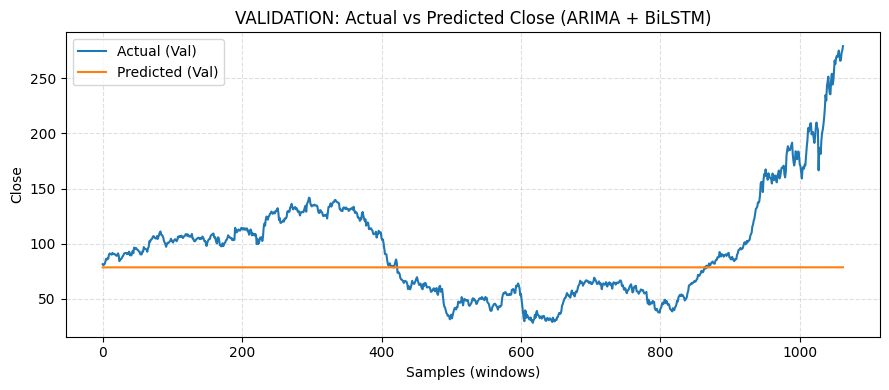


Summary:
                     MSE        MAE       RMSE        R2     AdjR2         DA  \
Train          0.006960   0.032086   0.083428  0.999996  0.999996  94.094118   
Validation  2565.815186  38.056900  50.653876 -0.115298 -0.119515  48.824083   

                  U1  
Train       0.000811  
Validation  0.274006  


In [ ]:
# ============================================================
# Returns-Target + **Bi-Directional GRU only** — FAST edition (patched)
# AMP + XLA + tf.data | Metrics: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------- SPEED SWITCH ----------------
FAST = True                 # << flip to False for better accuracy
EPOCHS       = 100 if FAST else 60
BATCH_SIZE   = 256 if FAST else 128
STRIDE       = 3  if FAST else 1         # subsample windows to reduce dataset size
L1_UNITS     = 64 if FAST else 128
L2_UNITS     = 32 if FAST else 64
HEAD_WIDTH   = 48 if FAST else 96
DROPOUT      = 0.1 if FAST else 0.2
REC_DROPOUT  = 0.0                       # keep 0 to enable cuDNN fast path for GRU
# ------------------------------------------------------------

# --- Set threading BEFORE TF runtime is initialized ---
try:
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
except RuntimeError:
    # Runtime already initialized: skip without failing
    pass

# AMP + XLA (these lines can initialize runtime)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/stock_GE_Dataset.xlsx"   # change if needed
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

# keep only OHLCV (rename if needed)
data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) Sequences (returns target) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values

def create_sequences_for_return(data, seq_len=90, stride=1):
    X, y_ret, last_close = [], [], []
    for i in range(0, len(data) - seq_len, stride):
        j = i + seq_len
        X.append(data[i:j])
        c_t, c_t1 = data[j-1, CLOSE_IDX], data[j, CLOSE_IDX]
        y_ret.append((c_t1 - c_t) / (c_t + 1e-8))
        last_close.append(c_t)
    return np.array(X), np.array(y_ret), np.array(last_close)

X_raw, y_raw_ret, last_close_vec = create_sequences_for_return(raw_values, SEQ_LEN, STRIDE)

split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_ret_train, y_ret_val = y_raw_ret[:split], y_raw_ret[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 3) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]

# Keep 3D tensors for BiGRU (B, T, F); AMP ok (force final outputs to float32)
X_train = X_train.astype(np.float16)
X_val   = X_val.astype(np.float16)

y_train = y_ret_train.reshape(-1, 1).astype(np.float32)
y_val   = y_ret_val.reshape(-1, 1).astype(np.float32)

# ============ 4) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .cache()
            .shuffle(min(4096, len(X_train)), seed=SEED)
            .batch(BATCH_SIZE, drop_remainder=True)     # fast training, fixed batch
            .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
            .cache()
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTOTUNE))

# Non-shuffled, non-dropping datasets for evaluation/prediction (keep shapes aligned)
train_eval_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE, drop_remainder=False)
val_eval_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(BATCH_SIZE, drop_remainder=False)

# ============ 5) Build BiGRU-only model (cuDNN fast path) ============
def build_bigru_model(seq_len, n_features,
                      gru_units1=L1_UNITS, gru_units2=L2_UNITS,
                      dropout=DROPOUT, recur_drop=REC_DROPOUT,
                      head_width=HEAD_WIDTH, head_drop=DROPOUT,
                      lr=3e-4, huber_delta=1.0):
    inp = layers.Input(shape=(seq_len, n_features))  # (B,T,F)

    # cuDNN GRU fast path requires recurrent_dropout==0.0 (we set REC_DROPOUT=0.0 above)
    x = layers.Bidirectional(
        layers.GRU(gru_units1, return_sequences=True,
                   dropout=dropout, recurrent_dropout=recur_drop, reset_after=True)
    )(inp)

    x = layers.Bidirectional(
        layers.GRU(gru_units2, return_sequences=False,
                   dropout=dropout, recurrent_dropout=recur_drop, reset_after=True)
    )(x)

    x = layers.Dense(head_width, activation="relu")(x)
    if head_drop > 0:
        x = layers.Dropout(head_drop)(x)

    out = layers.Dense(1, activation="linear", dtype="float32")(x)  # 1-step return
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    return model

model = build_bigru_model(SEQ_LEN, n_features)

# ============ 6) Train ============
early = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early, reduce]
)

# ============ 7) Predict ============
# Use the non-dropping, non-shuffled datasets to keep lengths aligned with last_close_* vectors
y_pred_train_ret = model.predict(train_eval_ds, verbose=0).reshape(-1)
y_pred_val_ret   = model.predict(val_eval_ds,   verbose=0).reshape(-1)

y_true_train_ret = y_train.reshape(-1)
y_true_val_ret   = y_val.reshape(-1)

# Reconstruct close from returns base
y_pred_train_close = last_close_train * (1.0 + y_pred_train_ret)
y_true_train_close = last_close_train * (1.0 + y_true_train_ret)
y_pred_val_close   = last_close_val   * (1.0 + y_pred_val_ret)
y_true_val_close   = last_close_val   * (1.0 + y_true_val_ret)

# ============ 8) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close, y_pred_val_close,
                             y_true_val_ret,   y_pred_val_ret)

# ============ 9) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []), label="Train Loss")
plt.plot(history.history.get("val_loss", []), label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (BiGRU FAST)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (BiGRU FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (BiGRU FAST)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


TF: 2.19.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Columns after cleaning: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        Date      Open      High       Low     Close  Volume
0 1962-01-02  0.621680  0.632041  0.615463  0.619607  432682
1 1962-01-03  0.616498  0.616498  0.611317  0.613390  296467
2 1962-01-04  0.613390  0.618571  0.600957  0.606137  368581
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0033 - mse: 0.0066 - val_loss: 37.5720 - val_mse: 2567.7468 - learning_rate: 3.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0033 - mse: 0.0067 - val_loss: 37.5564 - val_mse: 2565.4771 - learning_rate: 3.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 37.5664 - val_mse: 2566.8118 - learning_rate: 3.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - mse: 0.0068 - val_loss: 37.5633 - val_mse: 2566.4355 - learning_rate: 3.0000e

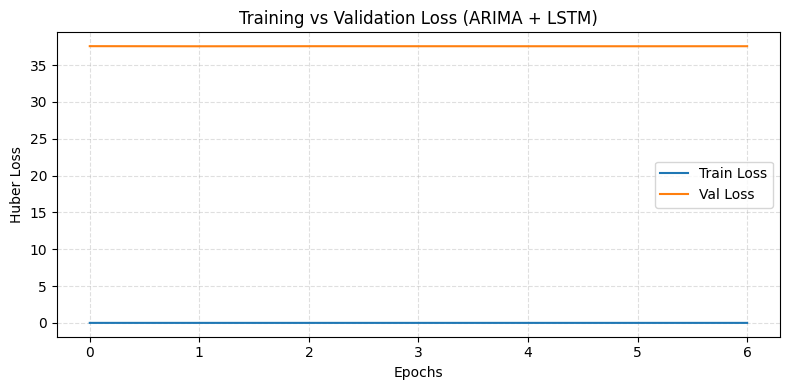

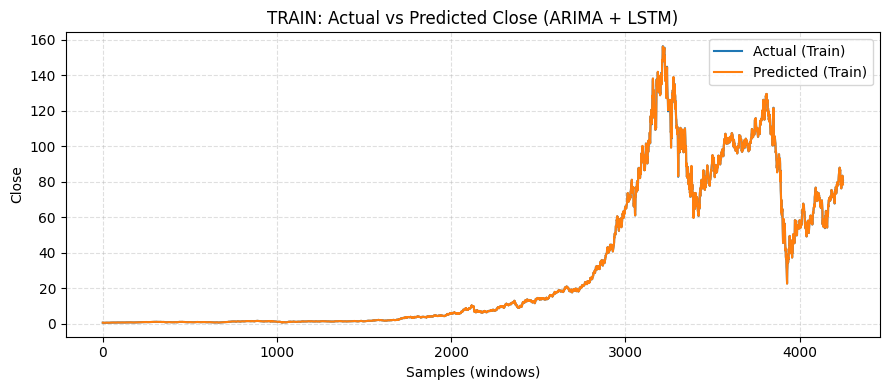

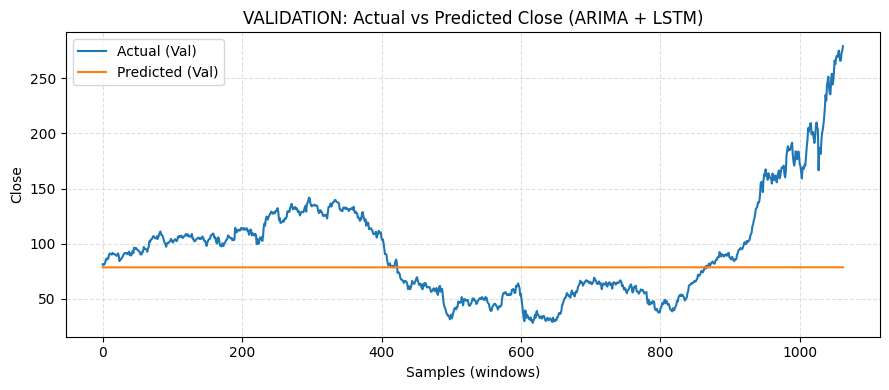


Summary:
                     MSE        MAE       RMSE        R2     AdjR2         DA  \
Train          0.007006   0.032645   0.083701  0.999996  0.999996  93.105882   
Validation  2565.477051  38.054737  50.650539 -0.115151 -0.120426  48.824083   

                  U1  
Train       0.000814  
Validation  0.273976  


In [ ]:
# ============================================================
# Hybrid ARIMA + LSTM (or BiLSTM) — FAST edition (patched)
# AMP + XLA + tf.data | Metrics: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- ARIMA
try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception as e:
    raise RuntimeError("statsmodels is required. Install with: pip install statsmodels") from e

# ---------------- SPEED / MODEL SWITCHES ----------------
FAST        = True                 # << flip to False for better accuracy
BIDIR       = False                # << False: LSTM | True: BiLSTM
EPOCHS      = 100 if FAST else 60
BATCH_SIZE  = 256 if FAST else 128
STRIDE      = 3  if FAST else 1    # subsample windows to reduce dataset size
L1_UNITS    = 64 if FAST else 128
L2_UNITS    = 32 if FAST else 64
HEAD_WIDTH  = 48 if FAST else 96
DROPOUT     = 0.1 if FAST else 0.2
REC_DROPOUT = 0.0                  # must be 0.0 for cuDNN fast path
ARIMA_ORDER = (2, 1, 2)            # tweak if needed
# --------------------------------------------------------

# --- Set threading BEFORE TF runtime is initialized ---
try:
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
except RuntimeError:
    pass

# AMP + XLA (these lines can initialize runtime)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH = "/content/GE1.xlsx"   # change if needed
SEQ_LEN    = 90
VAL_SPLIT  = 0.20
SEED       = 42

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

# keep only OHLCV (rename if needed)
data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# ============ 2) Build sequences (windows) ============
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")
raw_values = data_org[num_cols].astype(np.float32).values
close_all  = data_org["Close"].values.astype(np.float32)

def make_sequences(data, seq_len=90, stride=1):
    """
    Returns:
      X: windows ending at t (up to j-1)
      idx_next: absolute indices j locating the next target Close(t+1) in series
    """
    X, idx_next = [], []
    for i in range(0, len(data) - seq_len, stride):
        j = i + seq_len
        X.append(data[i:j])
        idx_next.append(j)   # next step after the window
    return np.array(X), np.array(idx_next)

X_raw, idx_next_all = make_sequences(raw_values, SEQ_LEN, STRIDE)
last_close_vec = raw_values[idx_next_all - 1, CLOSE_IDX]      # last close in each window
y_true_close_all = close_all[idx_next_all]                     # actual Close at t+1

# Train/Val split in sequence-space
split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val     = X_raw[:split], X_raw[split:]
idx_next_train, idx_next_val = idx_next_all[:split], idx_next_all[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]
y_true_close_train = y_true_close_all[:split]
y_true_close_val   = y_true_close_all[split:]

# ============ 3) ARIMA 1-step forecasts (fit on train slice only) ============
# Map sequence indices to raw series boundary for ARIMA fitting
max_next_train_idx = int(idx_next_train.max())            # last next index used in train
series_train_end   = max_next_train_idx                   # ARIMA sees data up to (series_train_end - 1)

close_series_train = close_all[:series_train_end].astype(np.float64)  # statsmodels prefers float64
arima_model = ARIMA(close_series_train, order=ARIMA_ORDER)
arima_res   = arima_model.fit(method_kwargs={"warn_convergence": False})

# In-sample one-step forecasts for train (index-aligned)
arima_pred_train_series = arima_res.predict(start=1, end=series_train_end, dynamic=False)
def gather_preds(pred_series, needed_indices):
    out = []
    for j in needed_indices:
        if j <= len(pred_series) - 1:
            out.append(pred_series[j])
        else:
            out.append(np.nan)
    return np.array(out, dtype=np.float32)

arima_pred_next_train = gather_preds(arima_pred_train_series, idx_next_train)

# Out-of-sample dynamic forecasts for validation
n_needed_val_steps = int(idx_next_val.max() - series_train_end)
if n_needed_val_steps < 1:
    n_needed_val_steps = 1
arima_forecast_val = arima_res.get_forecast(steps=n_needed_val_steps)
arima_pred_oos = arima_forecast_val.predicted_mean  # indices: series_train_end .. series_train_end+steps-1

arima_pred_next_val = []
for j in idx_next_val:
    k = j - series_train_end
    if 0 <= k < len(arima_pred_oos):
        arima_pred_next_val.append(arima_pred_oos[k])
    else:
        arima_pred_next_val.append(arima_pred_oos[-1])
arima_pred_next_val = np.array(arima_pred_next_val, dtype=np.float32)

# Fill any NaNs in train preds (early indices) with last observed close as fallback
nan_mask = np.isnan(arima_pred_next_train)
if nan_mask.any():
    arima_pred_next_train[nan_mask] = close_all[idx_next_train - 1][nan_mask]

# ============ 4) Residual targets for LSTM ============
# Residual = actual_close_(t+1) - arima_pred_(t+1)
y_resid_train = (y_true_close_train - arima_pred_next_train).astype(np.float32).reshape(-1, 1)
y_resid_val   = (y_true_close_val   - arima_pred_next_val).astype(np.float32).reshape(-1, 1)

# ============ 5) Scale X (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

def transform_windows(X):
    Xf = X.reshape(-1, X.shape[-1])
    Xf = robust_X.transform(Xf)
    Xf = minmax_X.transform(Xf)
    return Xf.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train = transform_windows(X_raw_train).astype(np.float16)
X_val   = transform_windows(X_raw_val).astype(np.float16)
n_features = X_train.shape[-1]

# ============ 6) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_resid_train))
            .cache()
            .shuffle(min(4096, len(X_train)), seed=SEED)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_resid_val))
            .cache()
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTOTUNE))

# For aligned predictions
train_eval_ds = tf.data.Dataset.from_tensor_slices((X_train, y_resid_train)).batch(BATCH_SIZE, drop_remainder=False)
val_eval_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_resid_val)).batch(BATCH_SIZE, drop_remainder=False)

# ============ 7) Build LSTM / BiLSTM ============
def build_rnn_model(seq_len, n_features,
                    units1=L1_UNITS, units2=L2_UNITS,
                    dropout=DROPOUT, recur_drop=REC_DROPOUT,
                    head_width=HEAD_WIDTH, head_drop=DROPOUT,
                    lr=3e-4, huber_delta=1.0, bidir=False):
    inp = layers.Input(shape=(seq_len, n_features))

    def rnn_layer(units, return_sequences):
        layer = layers.LSTM(units, return_sequences=return_sequences,
                            dropout=dropout, recurrent_dropout=recur_drop)
        return layers.Bidirectional(layer) if bidir else layer

    x = rnn_layer(units1, return_sequences=True)(inp)
    x = rnn_layer(units2, return_sequences=False)(x)

    x = layers.Dense(head_width, activation="relu")(x)
    if head_drop > 0:
        x = layers.Dropout(head_drop)(x)

    out = layers.Dense(1, activation="linear", dtype="float32")(x)  # residual output
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    return model

model = build_rnn_model(SEQ_LEN, n_features, bidir=BIDIR)

# ============ 8) Train ============
early  = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early, reduce]
)

# ============ 9) Predict residuals & reconstruct final Close ============
resid_hat_train = model.predict(train_eval_ds, verbose=0).reshape(-1)
resid_hat_val   = model.predict(val_eval_ds,   verbose=0).reshape(-1)

y_pred_close_train = arima_pred_next_train + resid_hat_train
y_pred_close_val   = arima_pred_next_val   + resid_hat_val

# Optional: returns for DA
y_true_ret_train = (y_true_close_train - last_close_train) / (last_close_train + 1e-8)
y_true_ret_val   = (y_true_close_val   - last_close_val)   / (last_close_val   + 1e-8)
y_pred_ret_train = (y_pred_close_train - last_close_train) / (last_close_train + 1e-8)
y_pred_ret_val   = (y_pred_close_val   - last_close_val)   / (last_close_val   + 1e-8)

# ============ 10) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n  = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return np.nan if n - p - 1 <= 0 else 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

# Effective predictors (proxy): number of input channels; you can +1 to count ARIMA explicitly
p_features = max(1, len(num_cols))  # or len(num_cols)+1

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_close_train, y_pred_close_train,
                             y_true_ret_train,   y_pred_ret_train)
val_metrics   = report_block("VALIDATION",
                             y_true_close_val,   y_pred_close_val,
                             y_true_ret_val,     y_pred_ret_val)

# ============ 11) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []), label="Train Loss")
plt.plot(history.history.get("val_loss", []), label="Val Loss")
ttl = "Training vs Validation Loss (ARIMA + " + ("BiLSTM" if BIDIR else "LSTM") + ")"
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title(ttl)
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_close_train, label="Actual (Train)")
plt.plot(y_pred_close_train, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (ARIMA + " + ("BiLSTM" if BIDIR else "LSTM") + ")")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_close_val, label="Actual (Val)")
plt.plot(y_pred_close_val, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (ARIMA + " + ("BiLSTM" if BIDIR else "LSTM") + ")")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


#ARIMA_GRU

TF: 2.19.0 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Columns after cleaning: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        Date      Open      High       Low     Close  Volume
0 1962-01-02  0.621680  0.632041  0.615463  0.619607  432682
1 1962-01-03  0.616498  0.616498  0.611317  0.613390  296467
2 1962-01-04  0.613390  0.618571  0.600957  0.606137  368581
Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.2328 - mse: 0.7928 - val_loss: 37.2904 - val_mse: 2509.6375 - learning_rate: 3.0000e-04
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2539 - mse: 0.9052 - val_loss: 37.2827 - val_mse: 2508.5378 - learning_rate: 3.0000e-04
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2303 - mse: 0.7835 - val_loss: 37.2901 - val_mse: 2509.6394 - learning_rate: 3.0000e-04
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2385 - mse: 0.8563 - val_loss: 37.2905 - val_mse: 2509.6194 - learning_rate: 3.0000e-04


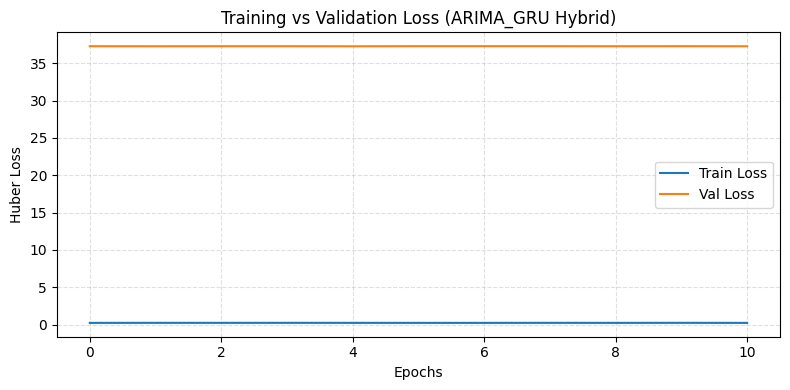

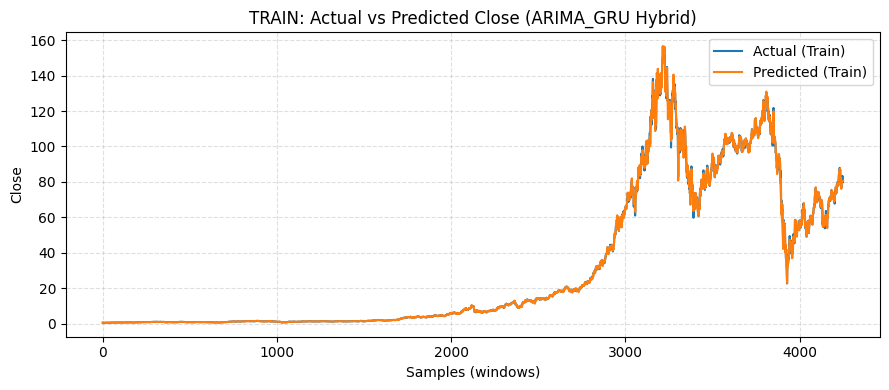

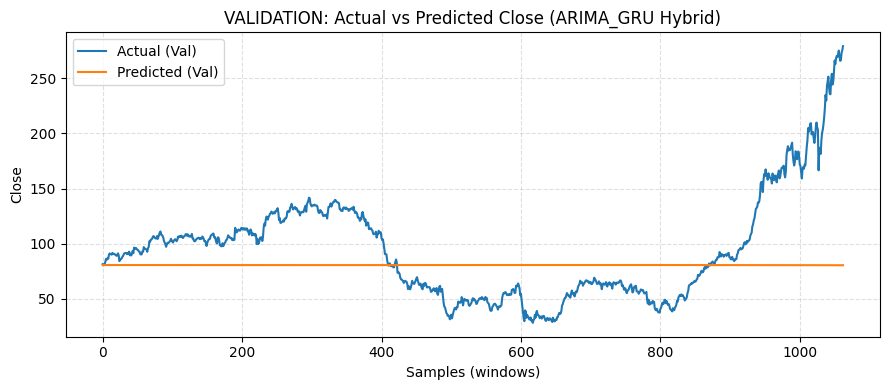


Summary:
                     MSE        MAE       RMSE        R2     AdjR2         DA  \
Train          0.854810   0.393967   0.924559  0.999486  0.999486  47.882353   
Validation  2507.879883  37.778049  50.078737 -0.090115 -0.094236  48.918156   

                  U1  
Train       0.008992  
Validation  0.267889  


In [ ]:
# ============================================================
# Returns-Target (reconstructed) + ARIMA_GRU Residual Hybrid — FAST edition
# AMP + XLA + tf.data | Metrics: MSE, MAE, RMSE, R², Adj R², DA, Theil's U1
# ============================================================
import os, sys, math, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- ARIMA ---
from statsmodels.tsa.arima.model import ARIMA

# ---------------- SPEED SWITCH ----------------
FAST = True                         # << flip to False for better accuracy (slower ARIMA)
EPOCHS       = 80 if FAST else 140
BATCH_SIZE   = 256 if FAST else 128
STRIDE       = 3  if FAST else 1
GRU_U1       = 64 if FAST else 128
GRU_U2       = 32 if FAST else 64
HEAD_WIDTH   = 48 if FAST else 96
DROPOUT      = 0.1 if FAST else 0.2
REC_DROPOUT  = 0.0                 # keep 0 to enable cuDNN fast path for GRU
# ------------------------------------------------------------

# --- Set threading BEFORE TF runtime is initialized ---
try:
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
except RuntimeError:
    pass

# AMP + XLA (these lines can initialize runtime)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# ============ Config ============
EXCEL_PATH  = "/content/stock_GE_Dataset.xlsx"   # change if needed
SEQ_LEN     = 90
VAL_SPLIT   = 0.20
SEED        = 42
ARIMA_ORDER = (2,1,2)               # you can tune this

# ============ Reproducibility ============
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
try: tf.keras.utils.set_random_seed(SEED)
except: pass

print("TF:", tf.__version__, "| GPU:", tf.config.list_physical_devices("GPU"))

# ============ 1) Load & clean data ============
assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
data_org = pd.read_excel(EXCEL_PATH)

# keep only OHLCV (rename if needed)
data_org.rename(columns={
    'Date_': 'Date',
    'Close_GE': 'Close',
    'High_GE':  'High',
    'Low_GE':   'Low',
    'Open_GE':  'Open',
    'Volume_GE':'Volume'
}, inplace=True)

keep = ['Date','Open','High','Low','Close','Volume']
data_org = data_org[[c for c in keep if c in data_org.columns]].copy()

numeric_cols = [c for c in ['Open','High','Low','Close','Volume'] if c in data_org.columns]
for col in numeric_cols:
    data_org[col] = pd.to_numeric(data_org[col], errors="coerce")
data_org.dropna(subset=numeric_cols, inplace=True)
data_org.reset_index(drop=True, inplace=True)

print("Columns after cleaning:", list(data_org.columns))
print(data_org.head(3))

# Basic arrays
num_cols = data_org.select_dtypes(include=[np.number]).columns.tolist()
assert "Close" in num_cols, f"'Close' not in numeric columns: {num_cols}"
CLOSE_IDX = num_cols.index("Close")

values = data_org[num_cols].astype(np.float32).values
closes = values[:, CLOSE_IDX].astype(np.float32)

# ============ 2) Fit ARIMA on Close & get one-step predictions ============
# Train/Val split index in absolute time
n = len(values)
split_abs = int((1.0 - VAL_SPLIT) * n)

# Fit ARIMA on the TRAIN segment only
train_close = closes[:split_abs]
val_close   = closes[split_abs:]

# Note: For speed we fit once on train and produce:
#   - in-sample one-step predictions for train (dynamic=False)
#   - out-of-sample forecasts for validation horizon
# If you want rolling refits, implement a loop (slower, sometimes better).
arima = ARIMA(train_close, order=ARIMA_ORDER, enforce_stationarity=False, enforce_invertibility=False)
arima_fit = arima.fit()

# In-sample one-step-ahead preds for train indices (aligned to train)
# The first few may be NaN depending on differencing; handle safely.
pred_in = arima_fit.get_prediction(start=0, end=len(train_close)-1, dynamic=False)
pred_train = pred_in.predicted_mean.astype(np.float32)

# Out-of-sample forecasts for the validation horizon length
pred_out = arima_fit.get_forecast(steps=len(val_close))
pred_val = pred_out.predicted_mean.astype(np.float32)

# Concatenate to have ARIMA baseline aligned with full series
arima_all = np.concatenate([pred_train, pred_val], axis=0)
# Pad any NaNs at the head by copying the first non-NaN or using actuals
if np.isnan(arima_all[:5]).any():
    first_good = np.where(~np.isnan(arima_all))[0][0]
    arima_all[:first_good] = closes[:first_good]

# ============ 3) Build windows to learn residuals: y = actual_close - arima_pred ============
def make_windows_for_residuals(features, closes, arima_pred, seq_len=90, stride=1):
    X, y_resid, base_arima, last_close = [], [], [], []
    for i in range(0, len(features) - seq_len, stride):
        j = i + seq_len  # target index
        # skip targets where ARIMA baseline is not available
        if j >= len(arima_pred) or np.isnan(arima_pred[j]):
            continue
        X.append(features[i:j])
        # residual at time j
        y_resid.append(closes[j] - arima_pred[j])
        # store baseline to reconstruct final forecast later
        base_arima.append(arima_pred[j])
        # previous true close for return-based metrics
        last_close.append(closes[j-1])
    return np.array(X), np.array(y_resid), np.array(base_arima), np.array(last_close)

X_raw, y_raw_resid, base_arima_vec, last_close_vec = make_windows_for_residuals(
    values, closes, arima_all, SEQ_LEN, STRIDE
)

# align split on windowed dataset (chronological)
split = int((1.0 - VAL_SPLIT) * len(X_raw))
X_raw_train, X_raw_val = X_raw[:split], X_raw[split:]
y_resid_train, y_resid_val = y_raw_resid[:split], y_raw_resid[split:]
base_arima_train, base_arima_val = base_arima_vec[:split], base_arima_vec[split:]
last_close_train, last_close_val = last_close_vec[:split], last_close_vec[split:]

# ============ 4) Scaling (Robust -> MinMax) ============
robust_X = RobustScaler()
minmax_X = MinMaxScaler()

flat_train = X_raw_train.reshape(-1, X_raw_train.shape[-1])
robust_X.fit(flat_train)
train_rob = robust_X.transform(flat_train)
minmax_X.fit(train_rob)

X_train = minmax_X.transform(train_rob).reshape(X_raw_train.shape[0], SEQ_LEN, X_raw_train.shape[-1])
X_val   = minmax_X.transform(
            robust_X.transform(X_raw_val.reshape(-1, X_raw_val.shape[-1]))
         ).reshape(X_raw_val.shape[0], SEQ_LEN, X_raw_val.shape[-1])

n_features = X_train.shape[-1]

# Keep 3D tensors for GRU; AMP ok (force final outputs to float32)
X_train = X_train.astype(np.float16)
X_val   = X_val.astype(np.float16)

y_train = y_resid_train.reshape(-1, 1).astype(np.float32)
y_val   = y_resid_val.reshape(-1, 1).astype(np.float32)

# ============ 5) tf.data ============
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .cache()
            .shuffle(min(4096, len(X_train)), seed=SEED)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
            .cache()
            .batch(BATCH_SIZE, drop_remainder=False)
            .prefetch(AUTOTUNE))

train_eval_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE, drop_remainder=False)
val_eval_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(BATCH_SIZE, drop_remainder=False)

# ============ 6) Build GRU residual model (uni-directional) ============
def build_gru_residual_model(seq_len, n_features,
                             gru_u1=GRU_U1, gru_u2=GRU_U2,
                             dropout=DROPOUT, recur_drop=REC_DROPOUT,
                             head_width=HEAD_WIDTH, head_drop=DROPOUT,
                             lr=3e-4, huber_delta=1.0):
    inp = layers.Input(shape=(seq_len, n_features))  # (B,T,F)

    x = layers.GRU(gru_u1, return_sequences=True,
                   dropout=dropout, recurrent_dropout=recur_drop, reset_after=True)(inp)
    x = layers.GRU(gru_u2, return_sequences=False,
                   dropout=dropout, recurrent_dropout=recur_drop, reset_after=True)(x)

    x = layers.Dense(head_width, activation="relu")(x)
    if head_drop > 0:
        x = layers.Dropout(head_drop)(x)

    # Predict residual (Close units)
    out = layers.Dense(1, activation="linear", dtype="float32")(x)
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=Huber(delta=huber_delta), metrics=["mse"])
    return model

model = build_gru_residual_model(SEQ_LEN, n_features)

# ============ 7) Train ============
early = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early, reduce]
)

# ============ 8) Predict residuals & reconstruct final Close ============
y_pred_train_resid = model.predict(train_eval_ds, verbose=0).reshape(-1)
y_pred_val_resid   = model.predict(val_eval_ds,   verbose=0).reshape(-1)

# Final predictions = ARIMA baseline + GRU residual
y_pred_train_close = base_arima_train + y_pred_train_resid
y_pred_val_close   = base_arima_val   + y_pred_val_resid

# Ground truth closes at the same target indices:
# We already aligned when building windows, so:
y_true_train_close = (y_pred_train_close * 0)  # placeholder
y_true_val_close   = (y_pred_val_close * 0)
# Reconstruct y_true from residual definition: y_resid = close - arima_pred  => close = resid + arima_pred
y_true_train_close = y_resid_train + base_arima_train
y_true_val_close   = y_resid_val   + base_arima_val

# For returns-based directional accuracy:
y_pred_train_ret = (y_pred_train_close - last_close_train) / (last_close_train + 1e-8)
y_true_train_ret = (y_true_train_close - last_close_train) / (last_close_train + 1e-8)
y_pred_val_ret   = (y_pred_val_close   - last_close_val)   / (last_close_val   + 1e-8)
y_true_val_ret   = (y_true_val_close   - last_close_val)   / (last_close_val   + 1e-8)

# ============ 9) Metrics ============
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def adj_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def directional_accuracy_from_returns(y_true_ret, y_pred_ret):
    return 100.0 * np.mean(np.sign(y_true_ret) == np.sign(y_pred_ret))

def theils_u1(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    num = np.sqrt(np.mean((yp - yt)**2))
    den = np.sqrt(np.mean(yt**2)) + np.sqrt(np.mean(yp**2))
    return np.nan if den == 0 else num / den

p_features = max(1, len(num_cols) - 1)

def report_block(name, y_true_close, y_pred_close, y_true_ret, y_pred_ret):
    _mse  = mean_squared_error(y_true_close, y_pred_close)
    _mae  = mean_absolute_error(y_true_close, y_pred_close)
    _rmse = rmse(y_true_close, y_pred_close)
    _r2   = r2_score(y_true_close, y_pred_close)
    _adj  = adj_r2(y_true_close, y_pred_close, p_features)
    _da   = directional_accuracy_from_returns(y_true_ret, y_pred_ret)
    _u1   = theils_u1(y_true_close, y_pred_close)
    print(f"\n=== {name} Metrics ===")
    print(f"MSE   : {_mse:,.6f}")
    print(f"MAE   : {_mae:,.6f}")
    print(f"RMSE  : {_rmse:,.6f}")
    print(f"R²    : {_r2:,.6f}")
    print(f"Adj R²: {_adj:,.6f}")
    print(f"Directional Accuracy (%): {_da:,.2f}")
    print(f"Theil's U1: {_u1:,.6f}")
    return dict(MSE=_mse, MAE=_mae, RMSE=_rmse, R2=_r2, AdjR2=_adj, DA=_da, U1=_u1)

train_metrics = report_block("TRAIN",
                             y_true_train_close, y_pred_train_close,
                             y_true_train_ret,   y_pred_train_ret)
val_metrics   = report_block("VALIDATION",
                             y_true_val_close,   y_pred_val_close,
                             y_true_val_ret,     y_pred_val_ret)

# ============ 10) Plots ============
plt.figure(figsize=(8,4))
plt.plot(history.history.get("loss", []), label="Train Loss")
plt.plot(history.history.get("val_loss", []), label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Huber Loss"); plt.title("Training vs Validation Loss (ARIMA_GRU Hybrid)")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_train_close, label="Actual (Train)")
plt.plot(y_pred_train_close, label="Predicted (Train)")
plt.title("TRAIN: Actual vs Predicted Close (ARIMA_GRU Hybrid)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(y_true_val_close, label="Actual (Val)")
plt.plot(y_pred_val_close, label="Predicted (Val)")
plt.title("VALIDATION: Actual vs Predicted Close (ARIMA_GRU Hybrid)")
plt.xlabel("Samples (windows)"); plt.ylabel("Close")
plt.legend(); plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

try:
    summary = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
    print("\nSummary:\n", summary)
except Exception:
    pass


AttributeError: 'float' object has no attribute 'shape'